In [297]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.metrics import mean_squared_error
import joblib
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.spatial import distance
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Data behandling

## Load data

In [298]:
data = pd.read_csv('case1Data.txt', sep=',', skipinitialspace=True)
y_mean = data['y'].mean()
y_std = data['y'].std()
data_cat = data[['C_ 1', 'C_ 2', 'C_ 3', 'C_ 4', 'C_ 5']]
data_encoded = pd.get_dummies(data_cat).astype(int)
C1_dummy = pd.get_dummies(data['C_ 1'], dummy_na=True).astype(int)
NaN_col = C1_dummy.iloc[:, -1]
data_encoded.loc[NaN_col == 1, data_encoded.columns[:5]] = np.nan

In [299]:
data_norm = data.copy()
scaler = StandardScaler()
data_norm.iloc[:, :96] = scaler.fit_transform(data_norm.iloc[:, :96])
scaler_filename = 'scaler_KNNoptimize.pkl'
joblib.dump(scaler, scaler_filename)

data_tot = pd.concat([data_norm.iloc[:,:96],data_encoded], axis=1)
data_tot.iloc[:,90:].head()

x_90      x_91      x_92      x_93      x_94      x_95  C_ 1_G  C_ 1_H  \
0  2.284429  2.427215  0.665343       NaN  1.021911  1.103443     0.0     1.0   
1 -0.784123  0.339025       NaN  1.142396  0.923233  2.035764     0.0     0.0   
2 -0.153389  0.712576 -0.711439  0.077127  0.333162 -0.467096     0.0     0.0   
3  0.499961  0.399022  0.170284  0.778344  0.933975  1.279824     NaN     NaN   
4  0.837954       NaN  0.206586 -0.336497 -0.275123 -1.253445     1.0     0.0   

   C_ 1_I  C_ 1_J  ...  C_ 4_G  C_ 4_H  C_ 4_I  C_ 4_J  C_ 4_K  C_ 5_G  \
0     0.0     0.0  ...       0       0       0       0       1       0   
1     0.0     0.0  ...       1       0       0       0       0       1   
2     1.0     0.0  ...       0       1       0       0       0       1   
3     NaN     NaN  ...       0       0       0       0       1       1   
4     0.0     0.0  ...       0       0       0       0       1       0   

   C_ 5_H  C_ 5_I  C_ 5_J  C_ 5_K  
0       0       0       1       0  
1       0       0       0       0  
2       0       0       0       0  
3       0       0       0       0  
4       1       0       0       0  

[5 rows x 27 columns]

## KNN oprindelig

In [300]:
K = 1
knn_imputer = KNNImputer(n_neighbors=K) 
data_imputed = pd.DataFrame(knn_imputer.fit_transform(data_tot), columns=data_tot.columns)
#data_imputed.iloc[:,96:101].head(10)

In [301]:
def replace_max_value(row):
    maks_værdi = row.max()
    return row.apply(lambda x: 1 if x == maks_værdi else 0)

data_imputed.iloc[:,96:101] = data_imputed.iloc[:,96:101].apply(replace_max_value, axis=1)
#data_imputed.iloc[:,94:].head(10)


### KNN antal

In [302]:
""" count_C1 = data_cat['C_ 1'].value_counts(dropna=True)

count_after = data_imputed.iloc[:, 96:101].sum()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

count_original.plot(kind='bar', color='blue', alpha=0.7, ax = ax[0])
ax[0].set_title('Count for C_1')
ax[0].set_xlabel('Category')
ax[0].set_ylabel('Count')

ax[1].bar(count_after.index, count_after, color='orange', alpha=0.7)
ax[1].set_title('Count after Imputation')
ax[1].set_xlabel('Category')
ax[1].set_ylabel('Count')

plt.show()

print("Sum of percentages for count_C1:", count_C1.sum())
print("Sum of percentages for count_after:", count_after.sum()) """

' count_C1 = data_cat[\'C_ 1\'].value_counts(dropna=True)\n\ncount_after = data_imputed.iloc[:, 96:101].sum()\n\nfig, ax = plt.subplots(1, 2, figsize=(12, 4))\n\ncount_C1.plot(kind=\'bar\', color=\'blue\', alpha=0.7, ax = ax[0])\nax[0].set_title(\'Count for C_1\')\nax[0].set_xlabel(\'Category\')\nax[0].set_ylabel(\'Count\')\n\nax[1].bar(count_after.index, count_after, color=\'orange\', alpha=0.7)\nax[1].set_title(\'Count after Imputation\')\nax[1].set_xlabel(\'Category\')\nax[1].set_ylabel(\'Count\')\n\nplt.show()\n\nprint("Sum of percentages for count_C1:", count_C1.sum())\nprint("Sum of percentages for count_after:", count_after.sum()) '

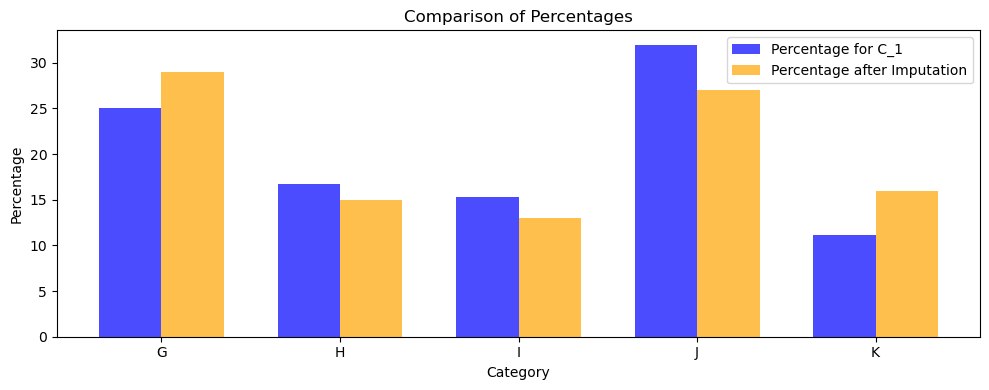

Sum of percentages for count_C1: 100.0
Sum of percentages for count_after: 100.0


In [303]:
count_C1 = data_cat['C_ 1'].value_counts(dropna=True)
count_after = data_imputed.iloc[:, 96:101].sum()
percentages_C1 = count_C1 / count_C1.sum() * 100
percentages_after = count_after / count_after.sum() * 100

percentages_C1_sorted = percentages_C1.sort_index()
percentages_after_sorted = percentages_after.sort_index()
index = np.arange(len(percentages_C1_sorted))
bar_width = 0.35

plt.figure(figsize=(10, 4))

plt.bar(index, percentages_C1_sorted, bar_width, color='blue', alpha=0.7, label='Percentage for C_1')
plt.bar(index + bar_width, percentages_after_sorted, bar_width, color='orange', alpha=0.7, label='Percentage after Imputation')

plt.title('Comparison of Percentages')
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.xticks(index + bar_width / 2, percentages_C1_sorted.index)
plt.legend()
plt.tight_layout()
plt.show()

print("Sum of percentages for count_C1:", percentages_C1.sum())
print("Sum of percentages for count_after:", percentages_after.sum())


In [304]:
scaler = joblib.load(scaler_filename)
data_done = data_tot.copy()
data_done.iloc[:, :96] = scaler.inverse_transform(data_imputed.iloc[:, :96].values)
data_done.iloc[:, 96:] = data_imputed.iloc[:, 96:]
data_done.head()


y       x_ 1       x_ 2      x_ 3      x_ 4       x_ 5      x_ 6  \
0  90.685036  24.062581  14.091650 -3.978178 -1.504027 -14.986790  0.651581   
1  60.844445  26.204958  11.185962 -8.247602 -3.875866 -11.329702  2.637900   
2  18.062345  18.560873  11.355342 -9.370161 -3.745315 -16.292421 -1.831774   
3  -8.139839  31.896496  10.069040 -9.484426 -1.512786 -11.421909 -5.649180   
4  -4.994792  25.400286  16.134188 -3.600959 -2.615988 -15.455676 -4.950816   

        x_ 7       x_ 8      x_ 9  ...  C_ 4_G  C_ 4_H  C_ 4_I  C_ 4_J  \
0 -37.878245  16.213807 -3.965437  ...     0.0     0.0     0.0     0.0   
1 -39.617497  16.996926 -2.442164  ...     1.0     0.0     0.0     0.0   
2 -37.584605  14.411348 -2.376175  ...     0.0     1.0     0.0     0.0   
3 -42.830037  18.403197 -7.791762  ...     0.0     0.0     0.0     0.0   
4 -39.932456  15.194819 -7.341165  ...     0.0     0.0     0.0     0.0   

   C_ 4_K  C_ 5_G  C_ 5_H  C_ 5_I  C_ 5_J  C_ 5_K  
0     1.0     0.0     0.0     0.0     1.0     0.0  
1     0.0     1.0     0.0     0.0     0.0     0.0  
2     0.0     1.0     0.0     0.0     0.0     0.0  
3     1.0     1.0     0.0     0.0     0.0     0.0  
4     1.0     0.0     1.0     0.0     0.0     0.0  

[5 rows x 117 columns]

In [305]:
data.head()

y       x_ 1       x_ 2      x_ 3      x_ 4       x_ 5      x_ 6  \
0  90.685036        NaN        NaN -3.978178 -1.504027 -14.986790  0.651581   
1  60.844445  26.204958  11.185962 -8.247602 -3.875866 -11.329702  2.637900   
2  18.062345  18.560873  11.355342 -9.370161 -3.745315 -16.292421 -1.831774   
3  -8.139839  31.896496  10.069040 -9.484426 -1.512786 -11.421909 -5.649180   
4  -4.994792  25.400286        NaN -3.600959 -2.615988 -15.455676 -4.950816   

        x_ 7       x_ 8      x_ 9  ...       x_91      x_92       x_93  \
0 -37.878245  16.213807 -3.965437  ...  -7.032047  6.319109        NaN   
1 -39.617497        NaN -2.442164  ... -13.437474       NaN -12.880342   
2 -37.584605  14.411348 -2.376175  ... -12.291624  2.664209 -15.803518   
3 -42.830037  18.403197 -7.791762  ... -13.253436  5.004891 -13.879328   
4 -39.932456        NaN -7.341165  ...        NaN  5.101262 -16.938532   

        x_94       x_95  C_ 1  C_ 2  C_ 3  C_ 4  C_ 5  
0  26.197445  -9.913837     H     H     I     K     J  
1  25.924603  -7.015803     K     H     J     G     G  
2  24.293073 -14.795709     I     H     G     H     G  
3  25.954304  -9.365574   NaN     H     K     K     G  
4  22.611184 -17.240003     G     H     H     K     H  

[5 rows x 101 columns]

Ud fra det ovenfor så ser det ud til at min kategoriske variable har ændre min korrelation lidt men det er stadig okay

## Kernal density plot
Nedenfor ses kernal dencity plot for mine variabler fra den oprindelig og behanldet data. Det er en tendens til, at mit data efter behandlingen er mere centeret omkring gennemsnitværdien

### Code


In [306]:
def knn_optimize(K_n, type_knn):
    knn_imputer = KNNImputer(n_neighbors=K_n, weights=type_knn) 
    data_imputed_def = pd.DataFrame(knn_imputer.fit_transform(data_tot), columns=data_tot.columns)
    data_imputed_def.iloc[:,96:101] = data_imputed.iloc[:,96:101].apply(replace_max_value, axis=1)
    scaler = joblib.load(scaler_filename)
    data_done_def = data_tot.copy()
    data_done_def.iloc[:, :96] = scaler.inverse_transform(data_imputed_def.iloc[:, :96].values)
    data_done_def.iloc[:, 96:] = data_imputed.iloc[:, 96:]
    return data_done_def

data_check = knn_optimize(1, 'distance')
data_check.head()
data.head(10)

y       x_ 1       x_ 2       x_ 3      x_ 4       x_ 5      x_ 6  \
0  90.685036        NaN        NaN  -3.978178 -1.504027 -14.986790  0.651581   
1  60.844445  26.204958  11.185962  -8.247602 -3.875866 -11.329702  2.637900   
2  18.062345  18.560873  11.355342  -9.370161 -3.745315 -16.292421 -1.831774   
3  -8.139839  31.896496  10.069040  -9.484426 -1.512786 -11.421909 -5.649180   
4  -4.994792  25.400286        NaN  -3.600959 -2.615988 -15.455676 -4.950816   
5 -71.946849  20.182342  11.442101 -15.848929 -5.433512 -18.470896 -3.772478   
6 -43.252217  21.581276   9.983328        NaN -0.190867        NaN -3.746710   
7  46.659819  23.541431  11.830937        NaN -3.960168        NaN -4.617966   
8 -46.682309  21.826025   9.841068 -10.822232 -9.082918 -17.277498 -7.583377   
9  59.962466  27.634692  15.437111        NaN -4.582242        NaN -2.733406   

        x_ 7       x_ 8      x_ 9  ...       x_91      x_92       x_93  \
0 -37.878245  16.213807 -3.965437  ...  -7.032047  6.319109        NaN   
1 -39.617497        NaN -2.442164  ... -13.437474       NaN -12.880342   
2 -37.584605  14.411348 -2.376175  ... -12.291624  2.664209 -15.803518   
3 -42.830037  18.403197 -7.791762  ... -13.253436  5.004891 -13.879328   
4 -39.932456        NaN -7.341165  ...        NaN  5.101262 -16.938532   
5 -39.311873  10.820767 -8.019431  ... -19.022602  0.099922        NaN   
6 -36.937439  12.199710 -6.301302  ... -14.268092  3.398466 -16.317353   
7 -41.043839  17.473770 -4.969147  ...        NaN  4.484645 -17.663410   
8 -37.240807  15.739363 -9.962687  ...        NaN       NaN -15.265148   
9 -39.461801  17.791352 -6.403260  ...        NaN -0.836152 -14.136879   

        x_94       x_95  C_ 1  C_ 2  C_ 3  C_ 4  C_ 5  
0  26.197445  -9.913837     H     H     I     K     J  
1  25.924603  -7.015803     K     H     J     G     G  
2  24.293073 -14.795709     I     H     G     H     G  
3  25.954304  -9.365574   NaN     H     K     K     G  
4  22.611184 -17.240003     G     H     H     K     H  
5  18.770601 -17.890958     I     H     K     J     K  
6  21.948563 -17.629762     J     H     G     K     H  
7  25.091233  -9.133498   NaN     H     H     J     J  
8  25.082441 -15.523372     J     H     H     I     K  
9  24.855741 -12.738811   NaN     H     J     H     I  

[10 rows x 101 columns]

In [307]:
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import jensenshannon
import numpy as np

def compute_jensen_shannon_divergence(vector1, vector2, kernel='gaussian', bandwidth=1.0, num_points=1000):
    # Fjern NaN-værdier fra vektor1
    vector1 = vector1[~np.isnan(vector1)]
    # Fjern NaN-værdier fra vektor2
    vector2 = vector2[~np.isnan(vector2)]
    
    # Konverter pandas Series til numpy arrays
    vector1 = np.array(vector1)
    vector2 = np.array(vector2)
    
    # Estimate KDE for vector1
    kde1 = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(vector1[:, None])
    # Estimate KDE for vector2
    kde2 = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(vector2[:, None])

    # Create a common set of evaluation points
    min_val = min(min(vector1), min(vector2))
    max_val = max(max(vector1), max(vector2))
    eval_points = np.linspace(min_val, max_val, num_points)

    # Evaluate KDEs at common points
    pdf1 = np.exp(kde1.score_samples(eval_points[:, None]))
    pdf2 = np.exp(kde2.score_samples(eval_points[:, None]))

    # Compute Jensen-Shannon divergence
    js_divergence = jensenshannon(pdf1, pdf2)

    return js_divergence

# Eksempel på brug:
vector1 = np.random.normal(loc=0, scale=1, size=1000)
vector2 = np.random.normal(loc=0.5, scale=1.2, size=800)

js_divergence = compute_jensen_shannon_divergence(data['y'], data_check['y'])
print("Jensen-Shannon Divergence:", js_divergence)


Jensen-Shannon Divergence: 2.2968393072627338e-09


In [308]:
def find_K(num_k, type):
    op_tab = np.zeros((num_k, 96))
    for K_l in range(1,num_k+1):
        print(K_l)
        data_optimize = knn_optimize(K_l, type)
        for i, col in enumerate(data.columns[:96]):
            j_value =  compute_jensen_shannon_divergence(data[col], data_optimize[col])
            op_tab[K_l - 1, i] = j_value
    return op_tab


In [309]:
num_k = 100
data_bad_uni  = np.zeros((num_k, 96))
data_good_uni = np.zeros((num_k, 96))
data_bad_dis  = np.zeros((num_k, 96))
data_good_dis = np.zeros((num_k, 96))
num_good_uni = 0
num_bad_uni = 0
num_good_dis = 0
num_bad_dis = 0

for type in ['uniform', 'distance']:
    if type == 'uniform':
        table_uni = find_K(num_k=num_k, type=type)
        num_good_uni = np.argmin(table_uni.mean(axis = 1)) + 1
        num_bad_uni = np.argmax(table_uni.mean(axis = 1)) + 1
        data_bad_uni = knn_optimize(num_bad_uni, type)
        data_good_uni = knn_optimize(num_good_uni, type)
    elif type == 'distance':
        table_dis = find_K(num_k=num_k, type=type)    
        num_good_dis = np.argmin(table_dis.mean(axis = 1)) + 1
        num_bad_dis = np.argmax(table_dis.mean(axis = 1)) + 1
        data_bad_dis = knn_optimize(num_bad_dis, type)
        data_good_dis = knn_optimize(num_good_dis, type)      

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


### Plots

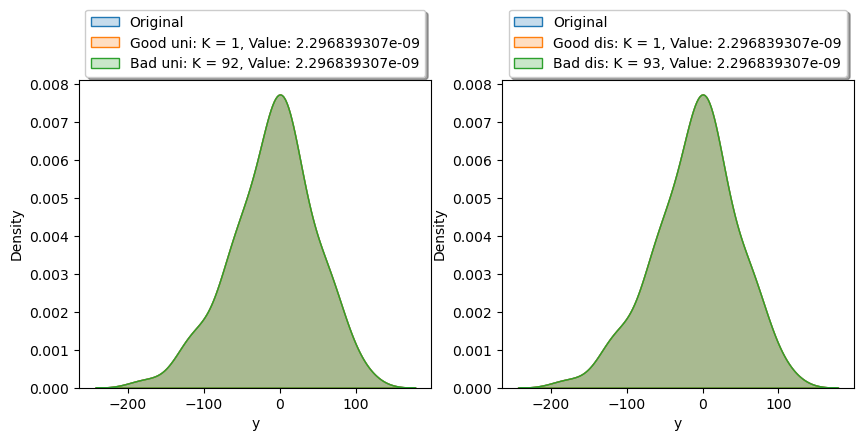

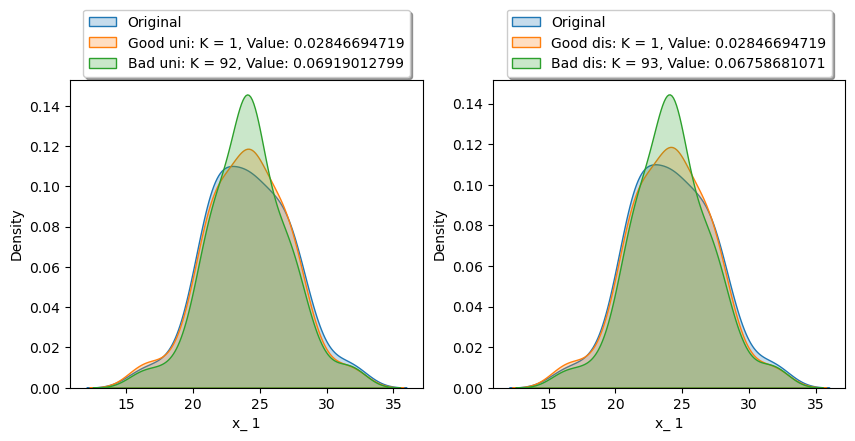

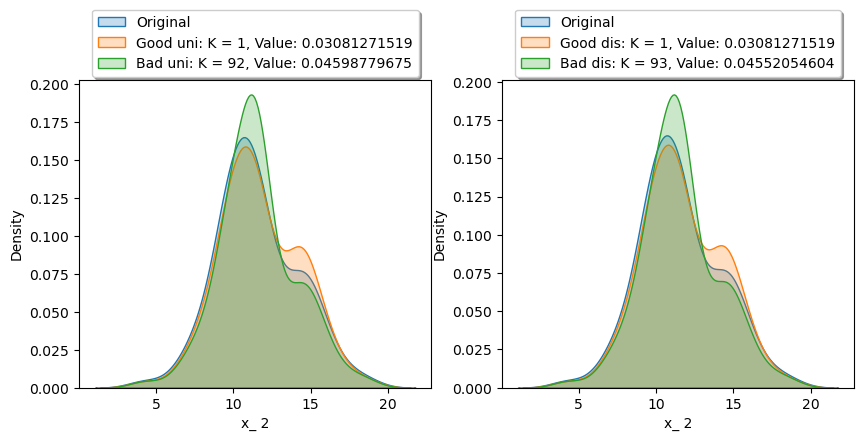

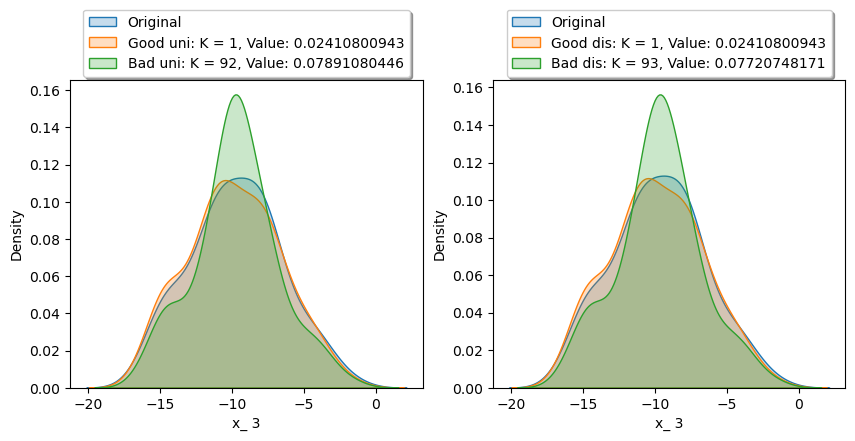

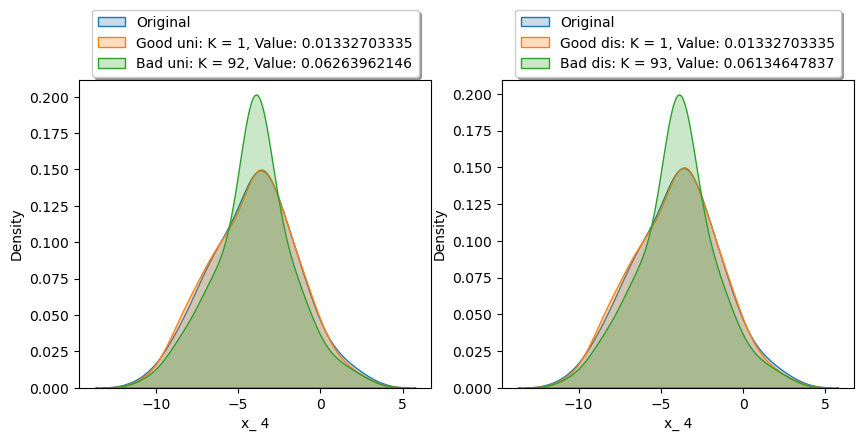

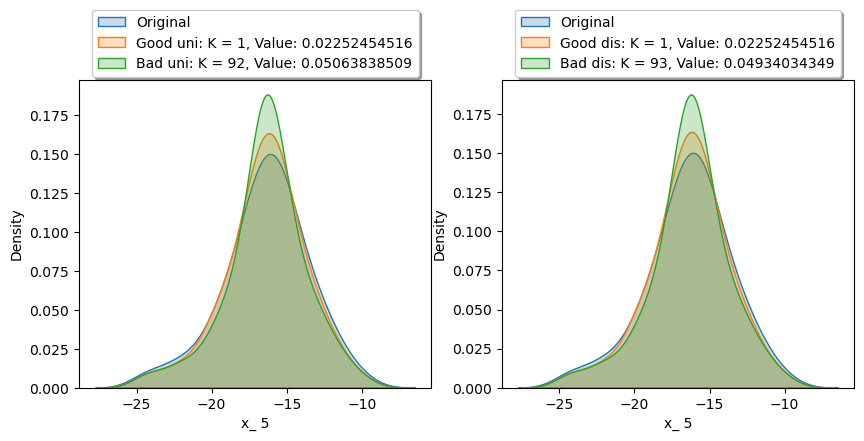

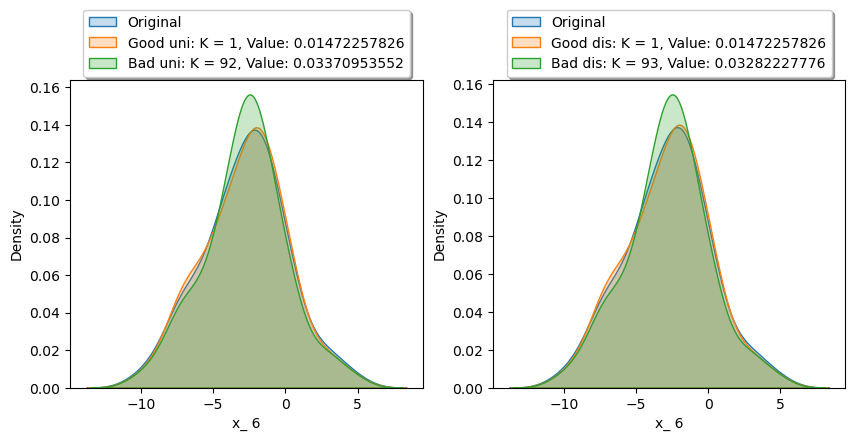

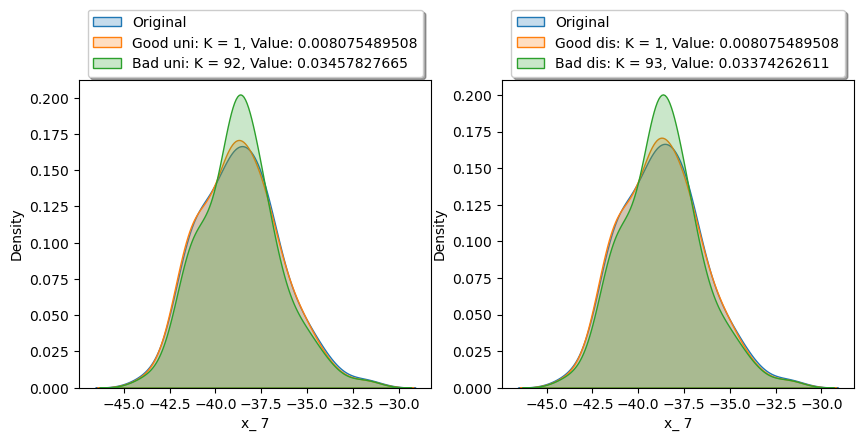

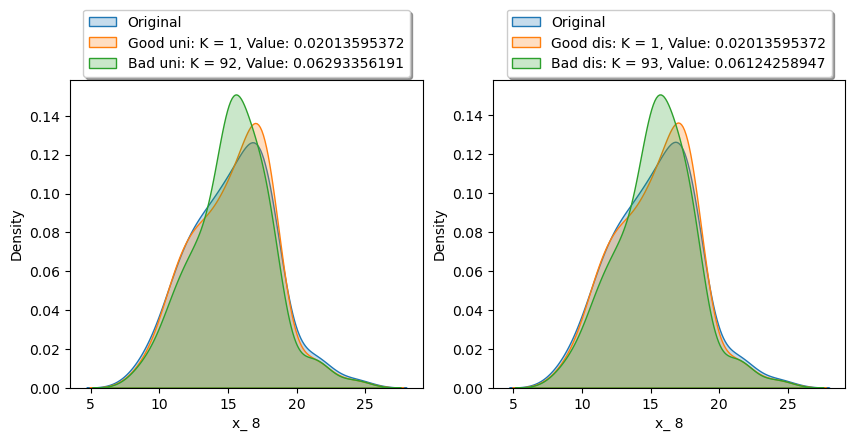

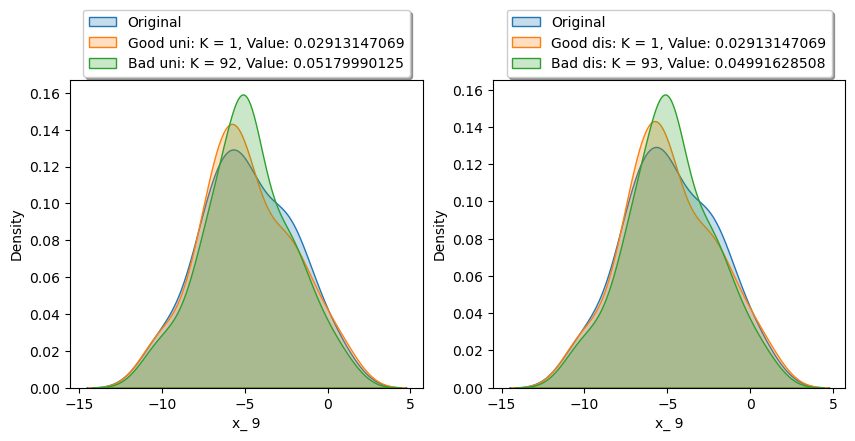

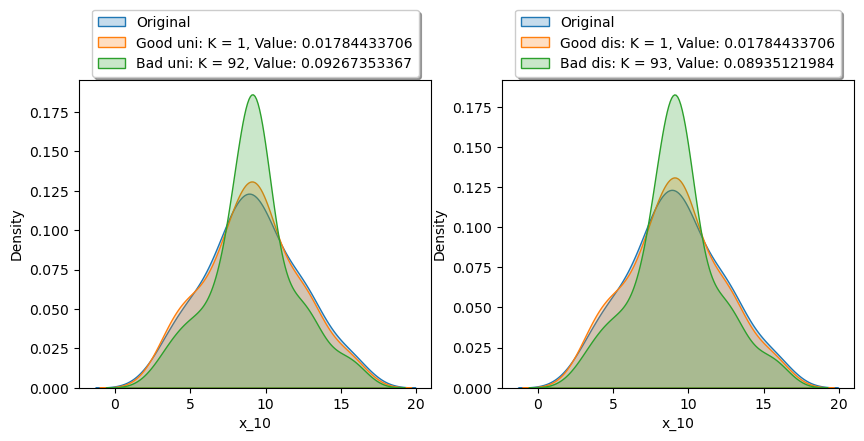

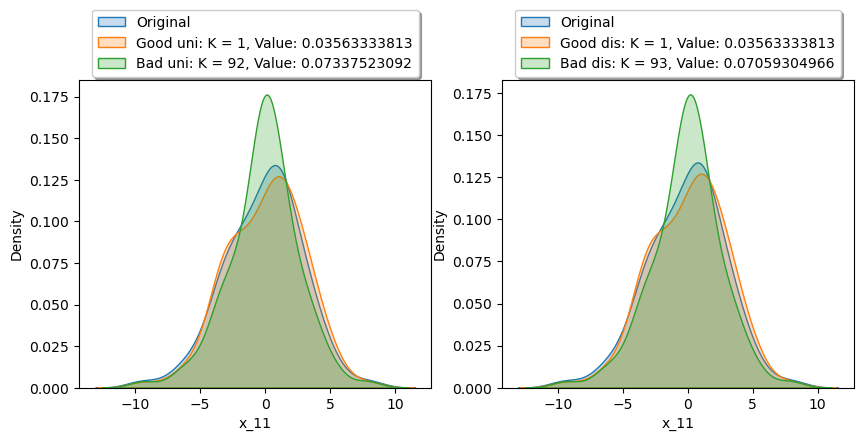

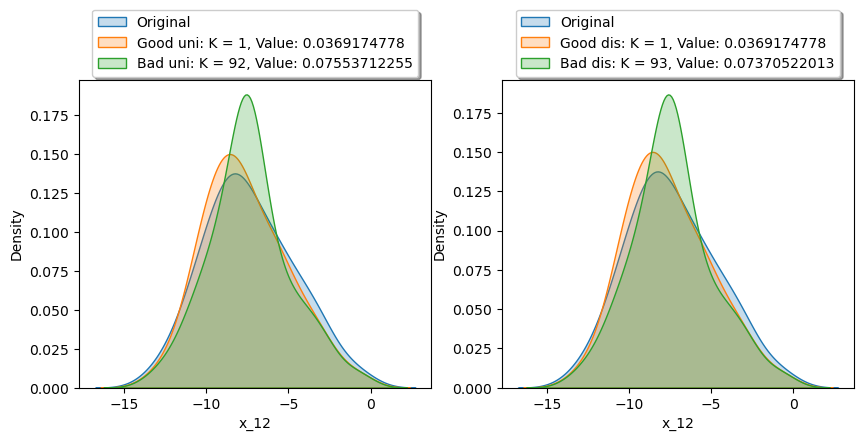

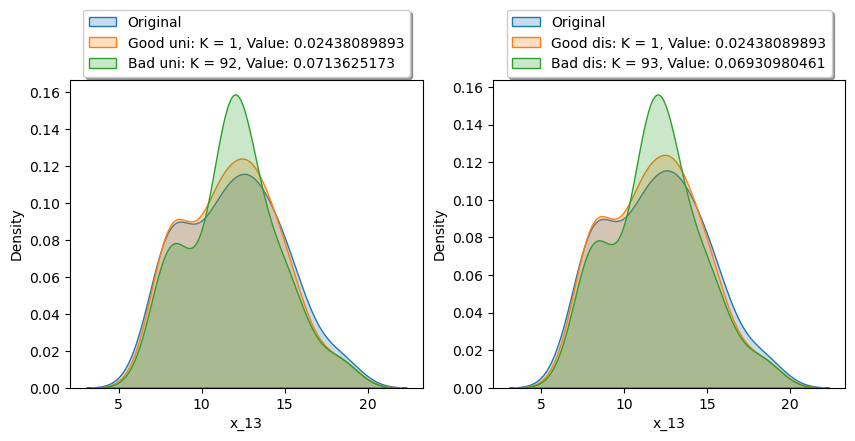

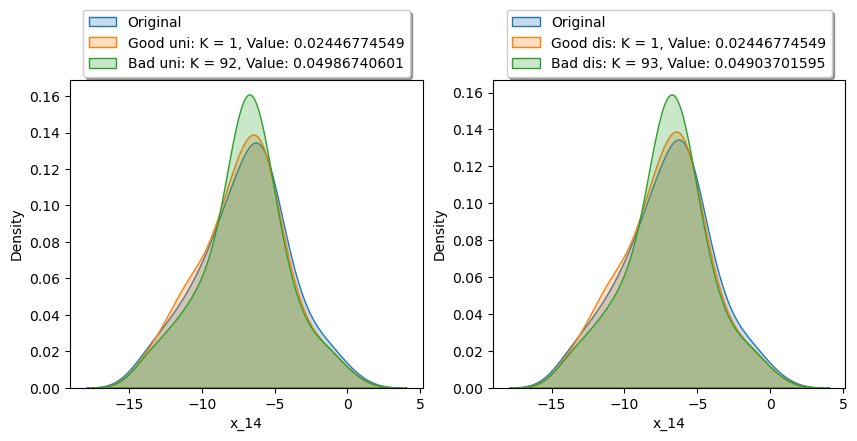

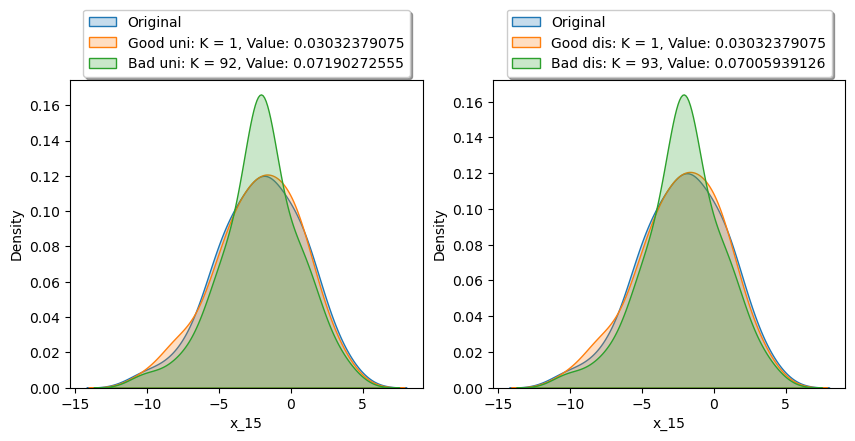

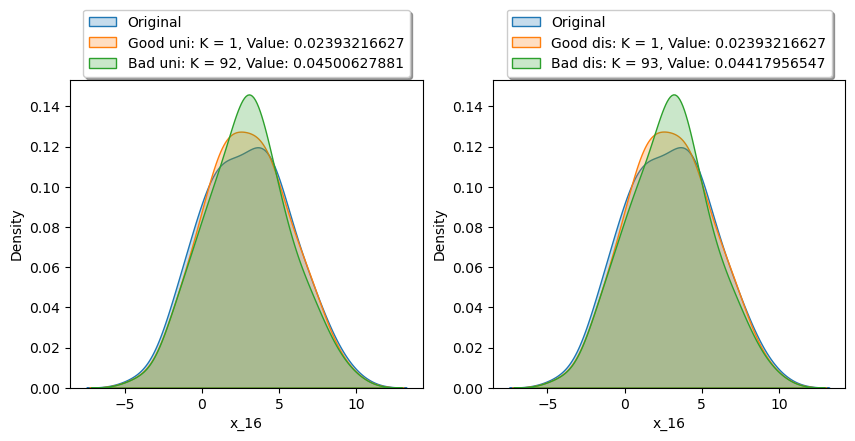

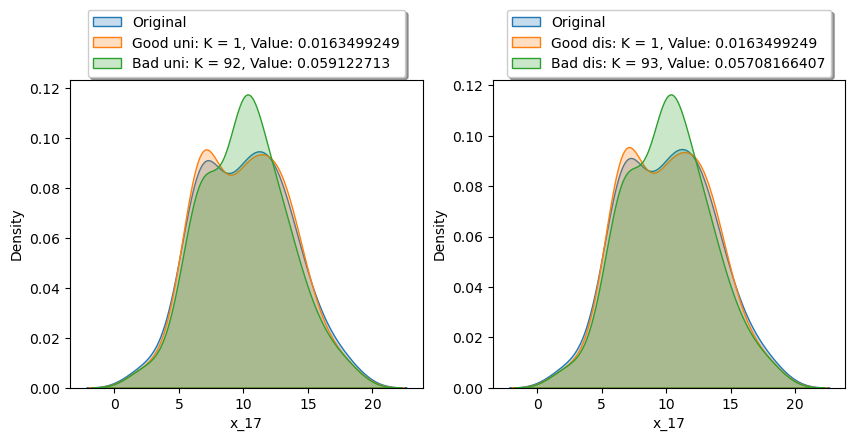

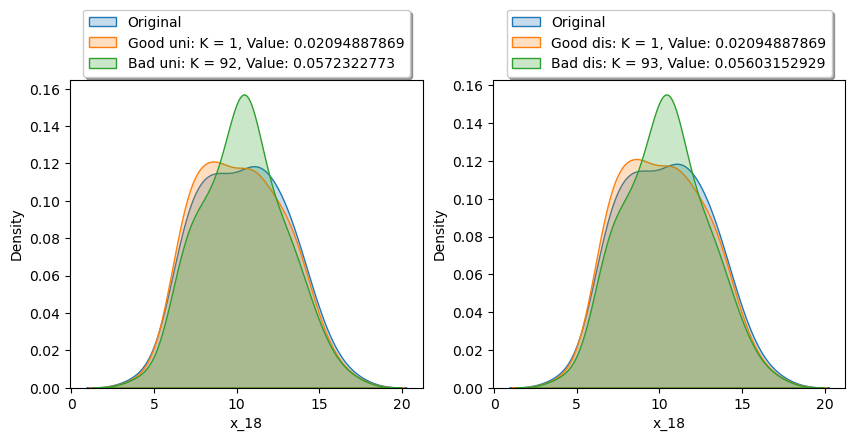

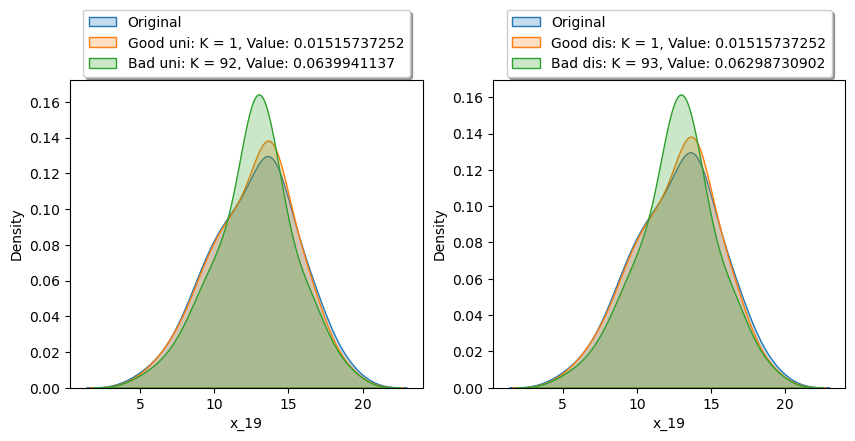

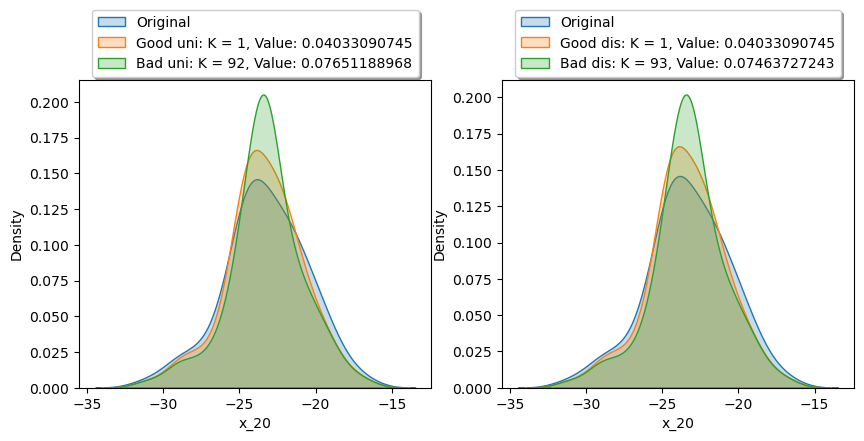

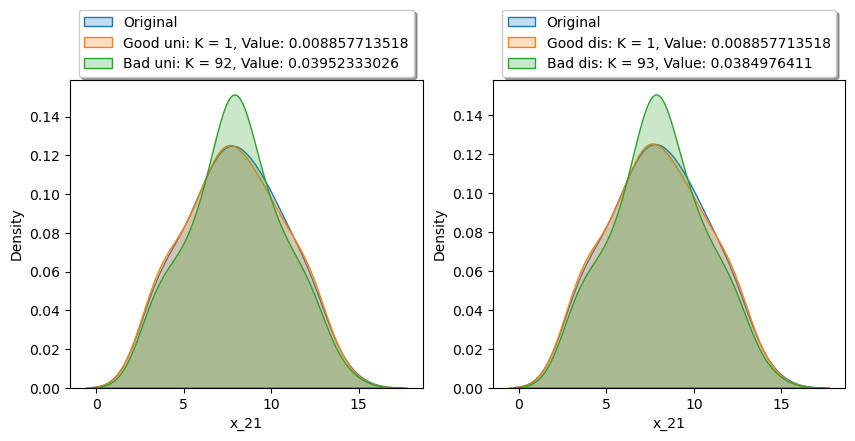

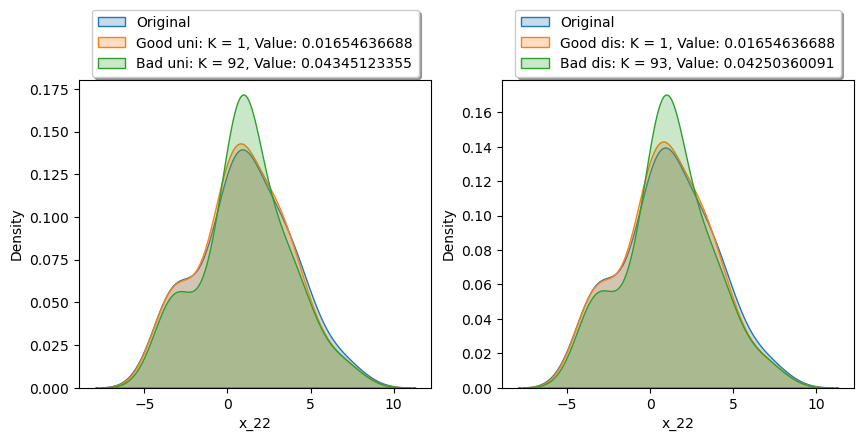

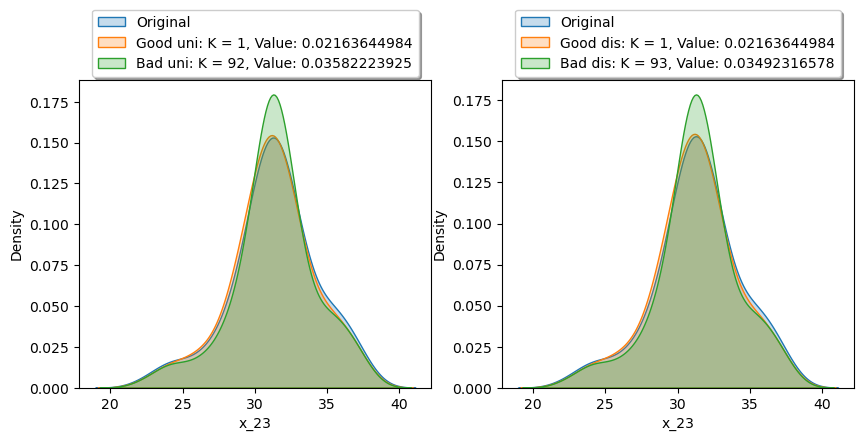

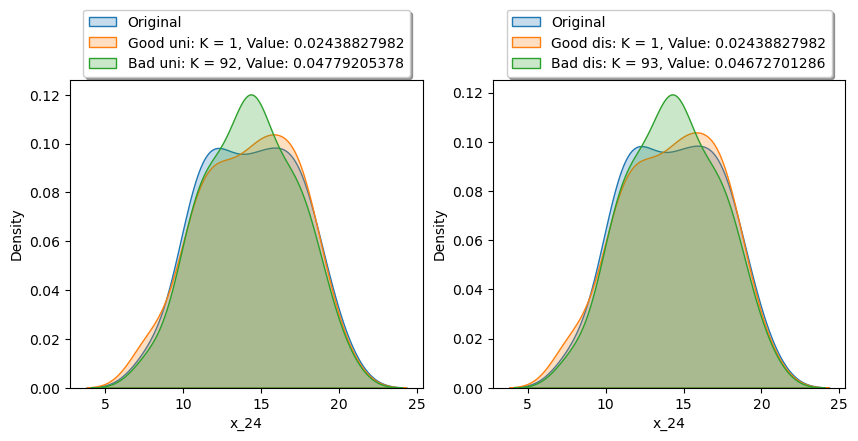

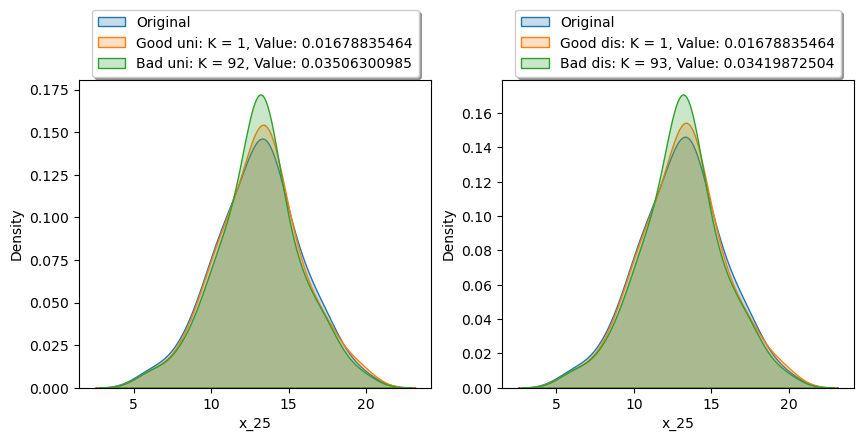

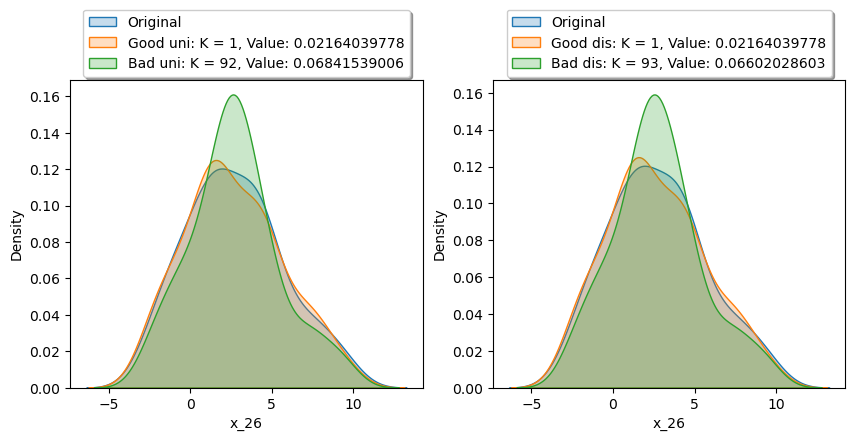

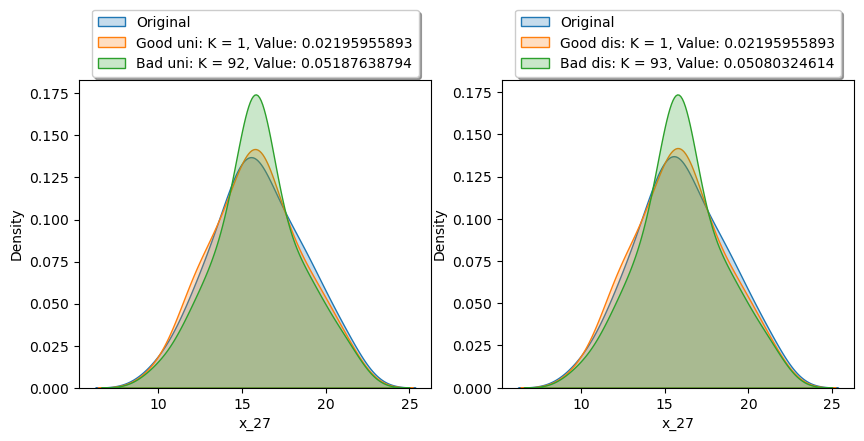

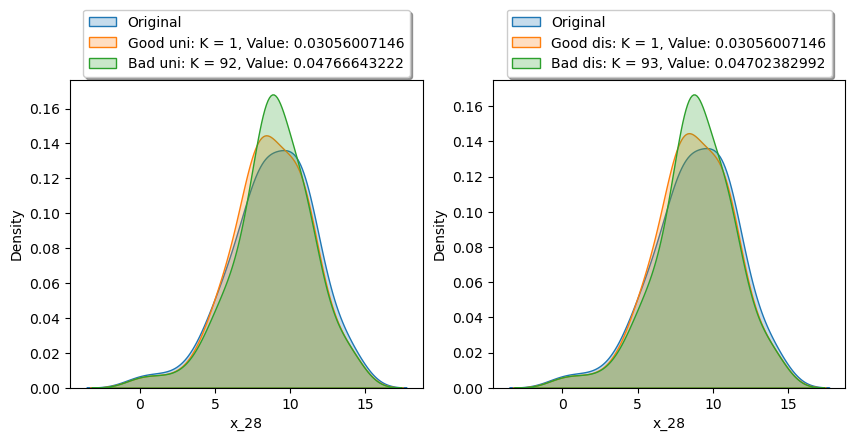

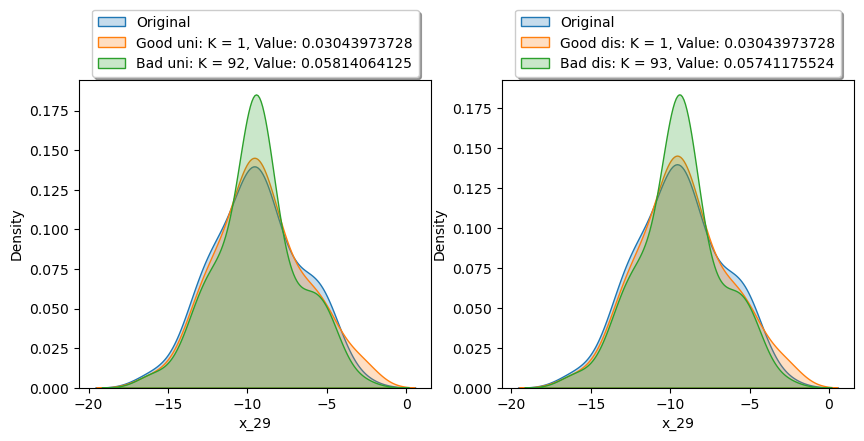

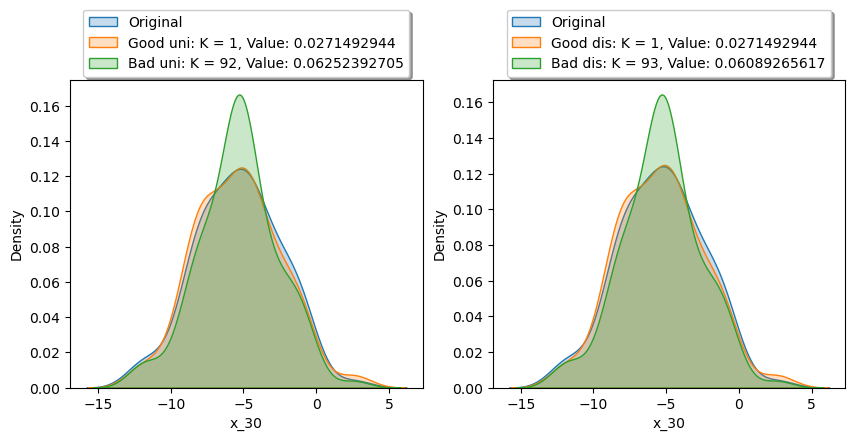

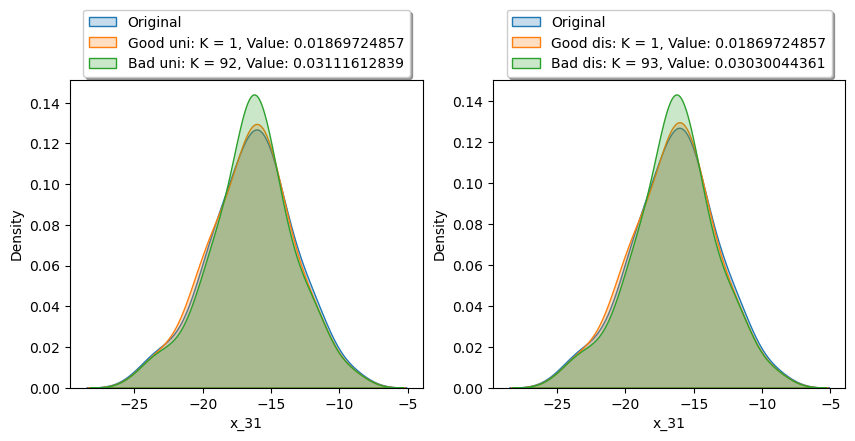

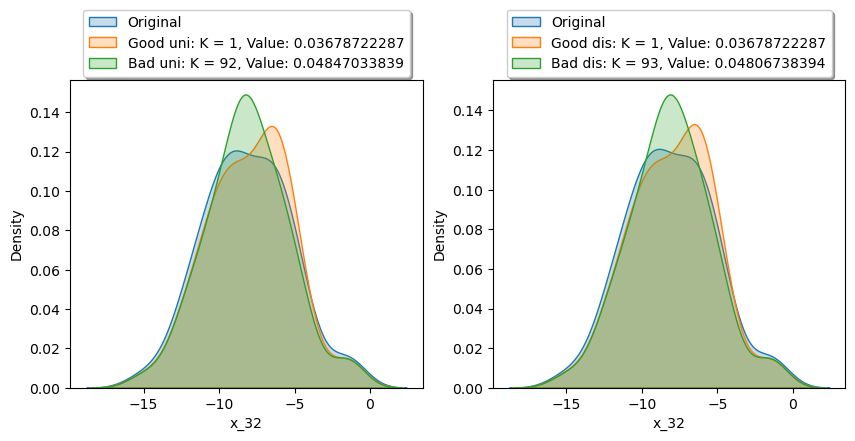

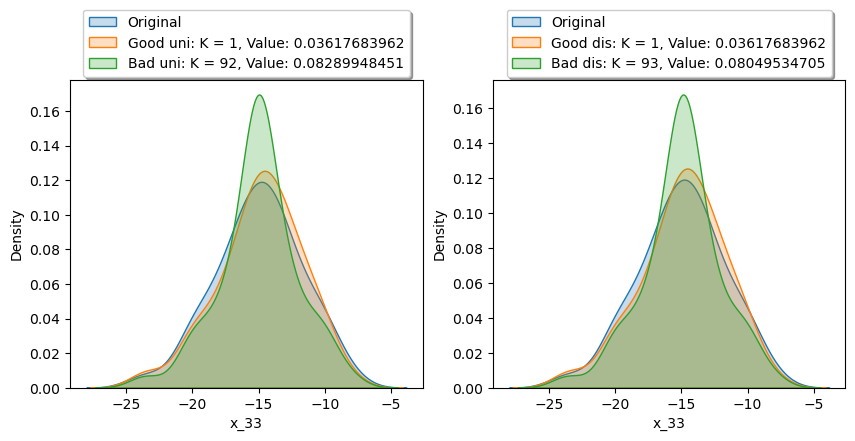

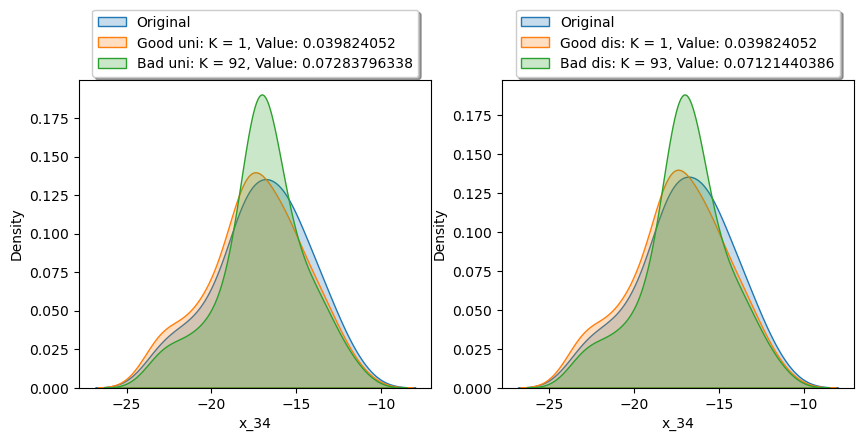

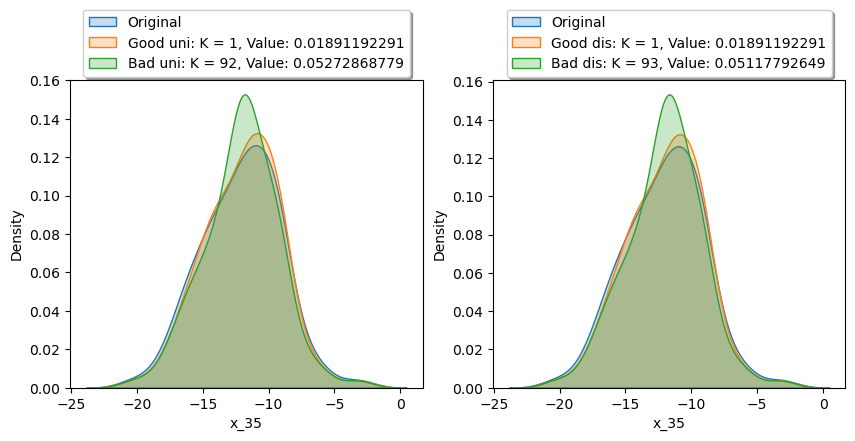

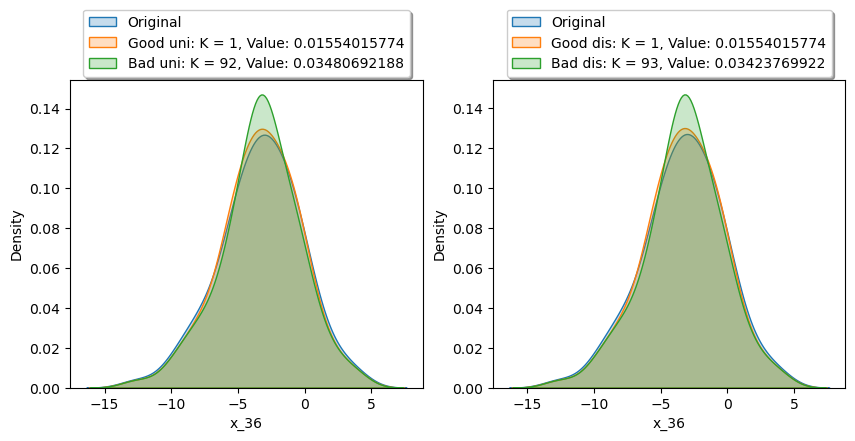

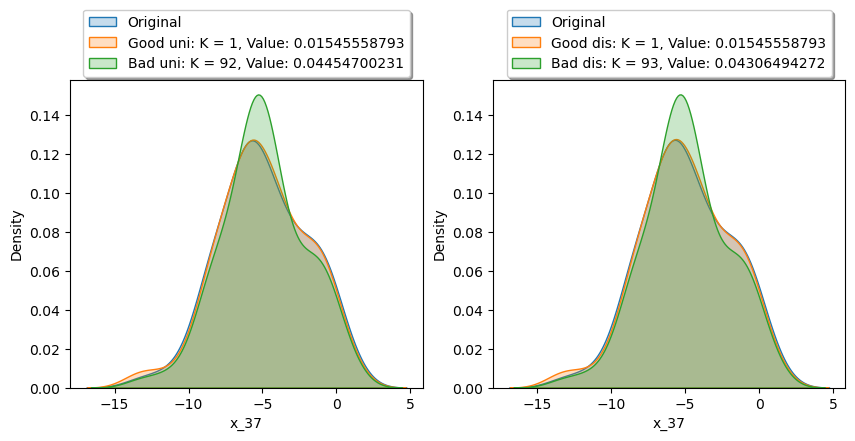

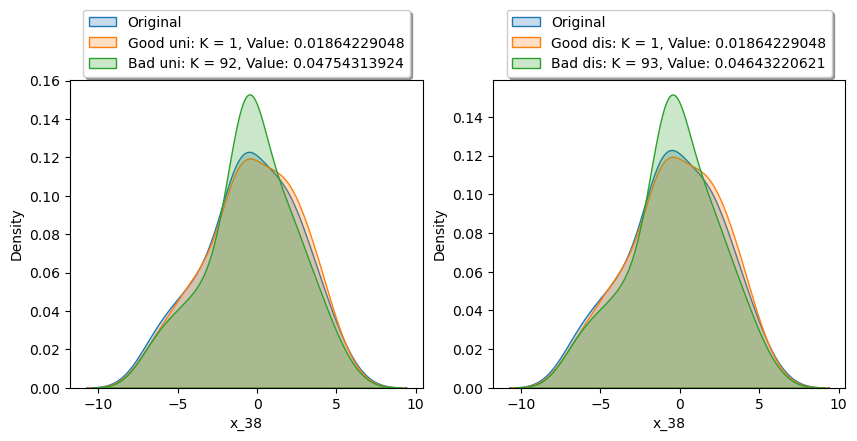

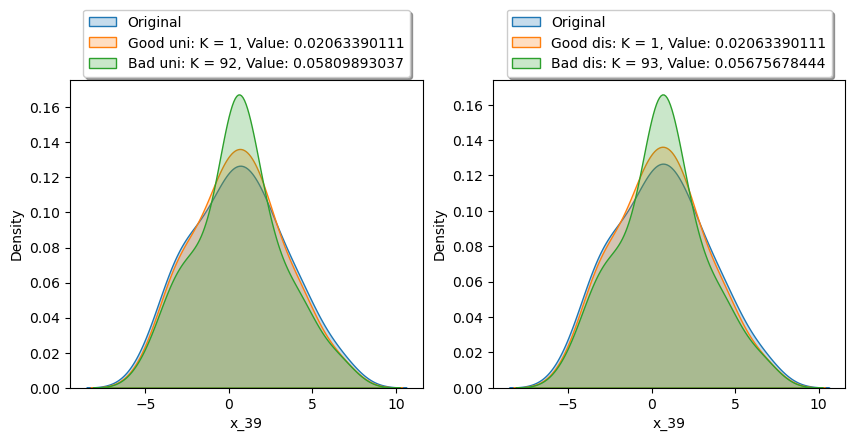

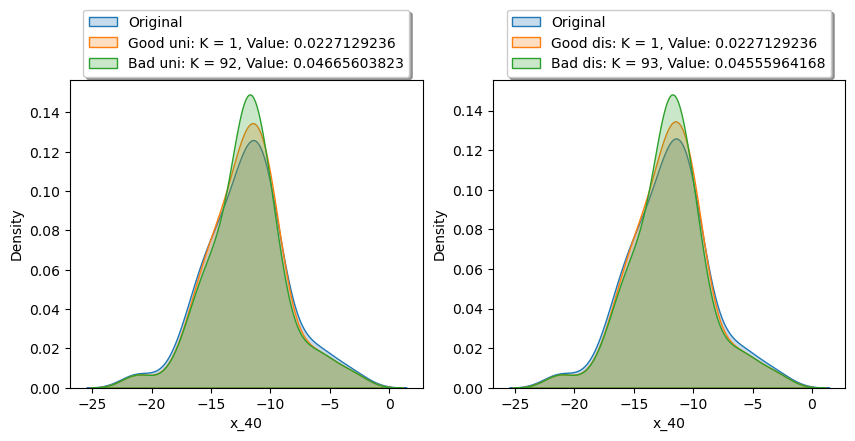

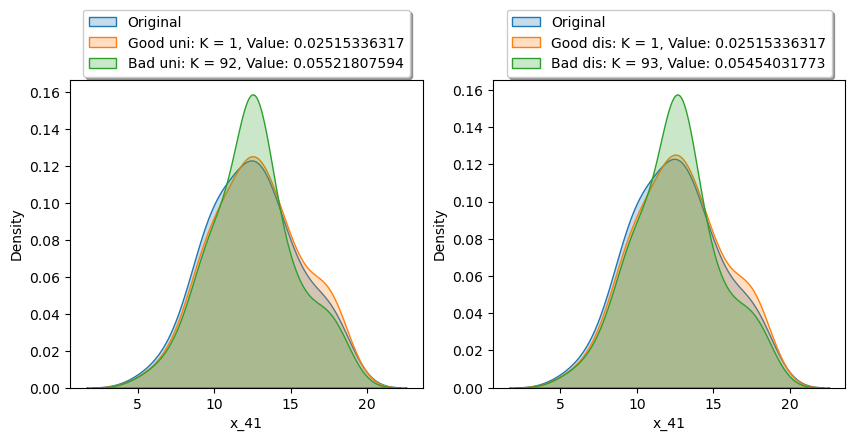

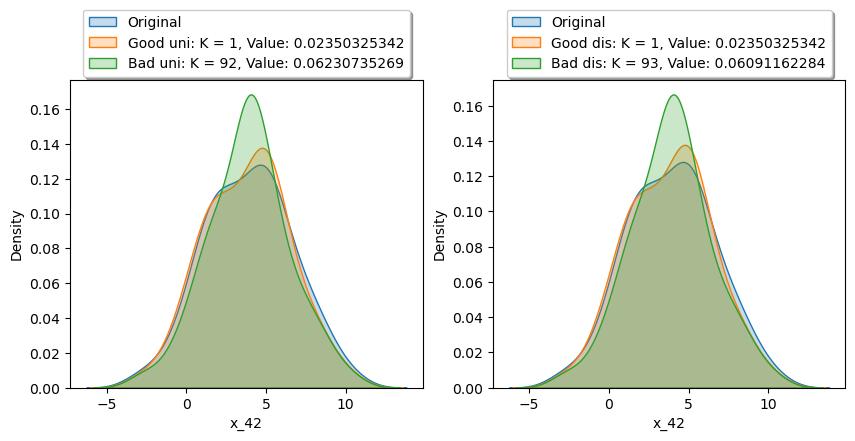

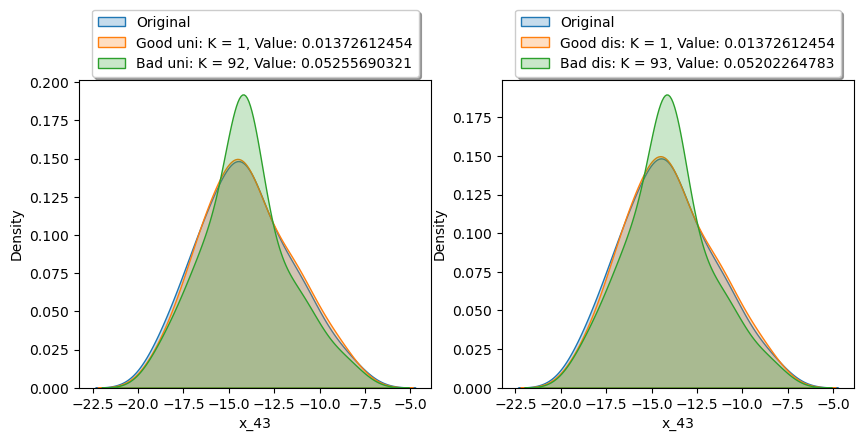

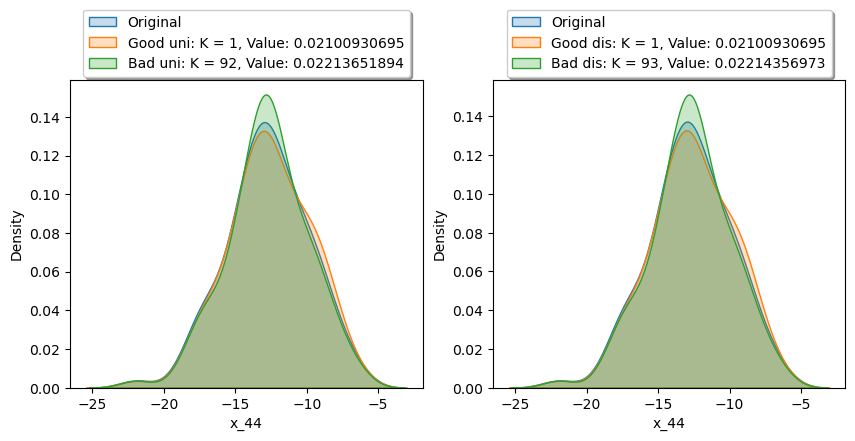

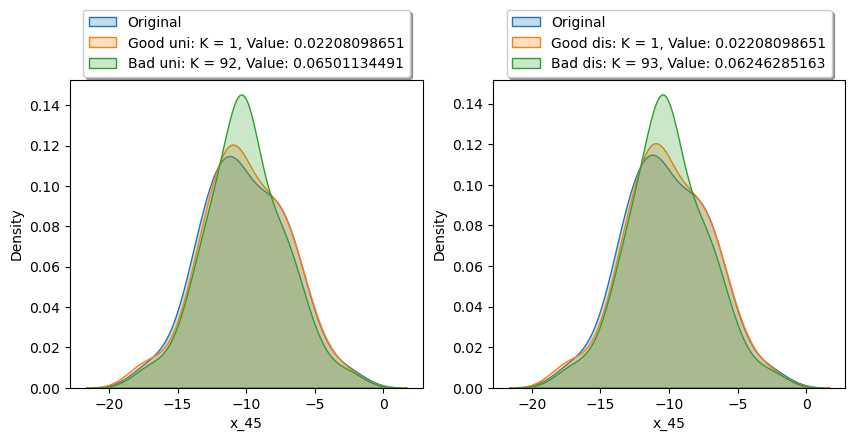

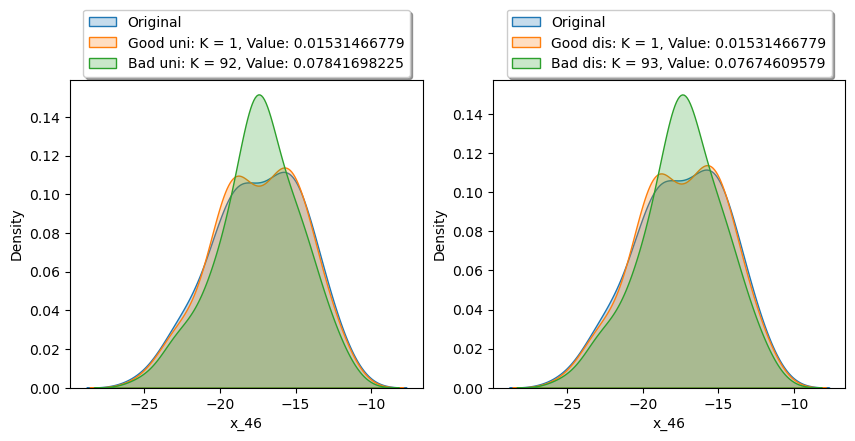

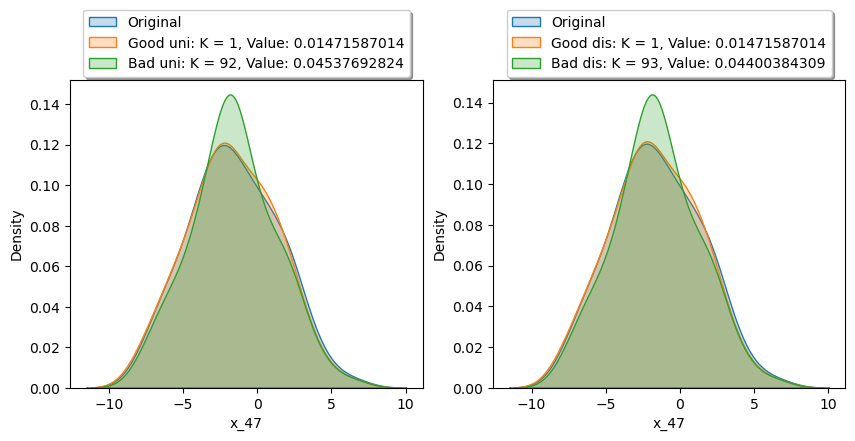

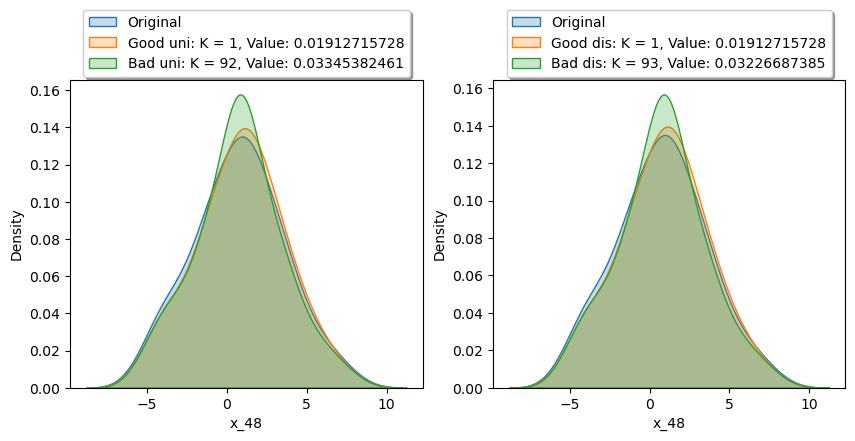

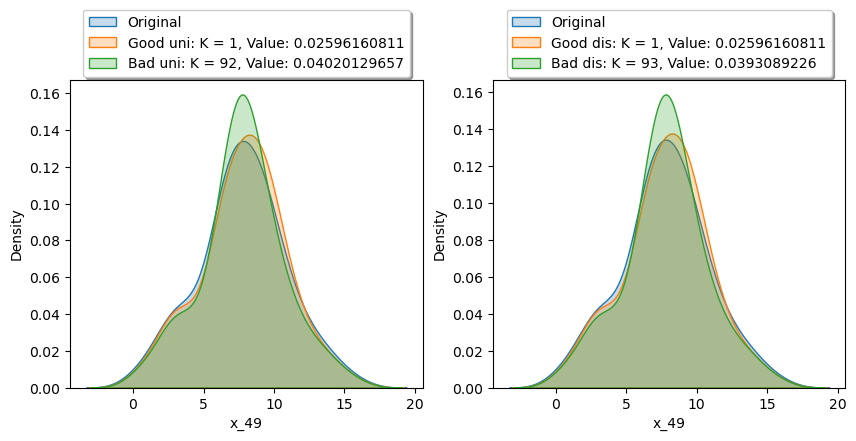

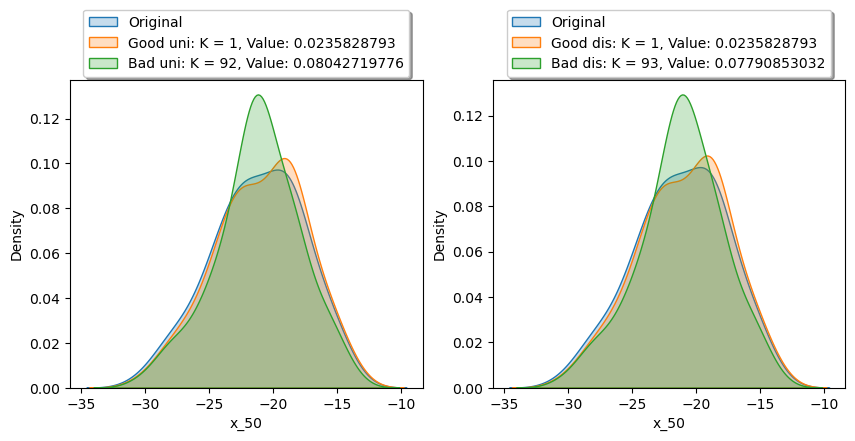

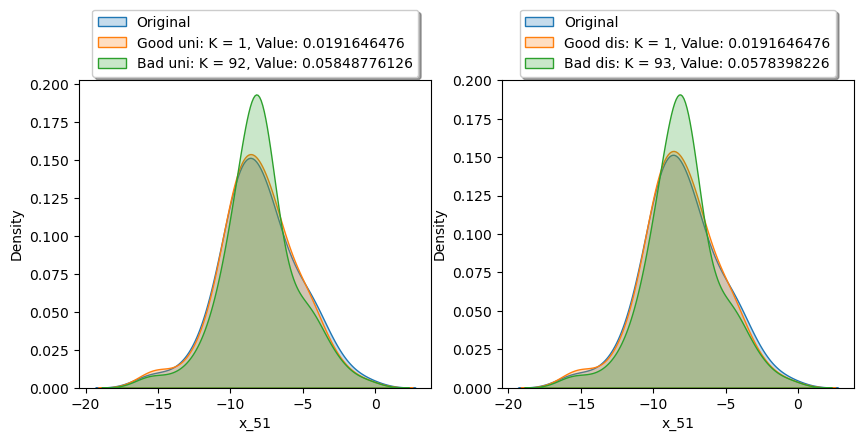

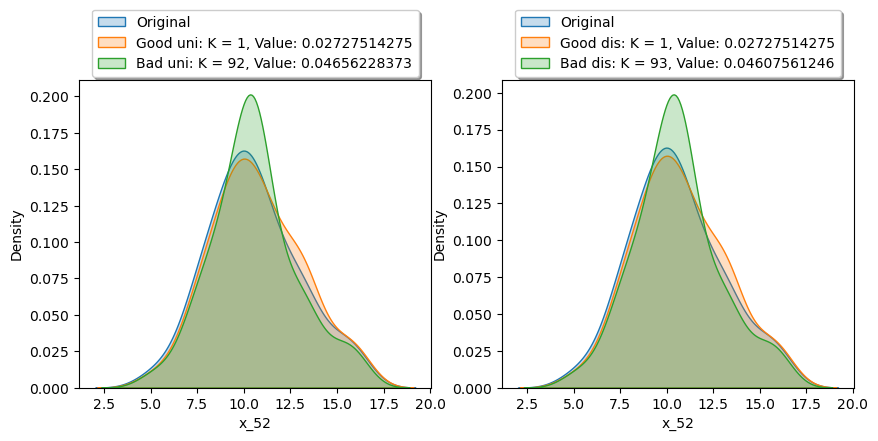

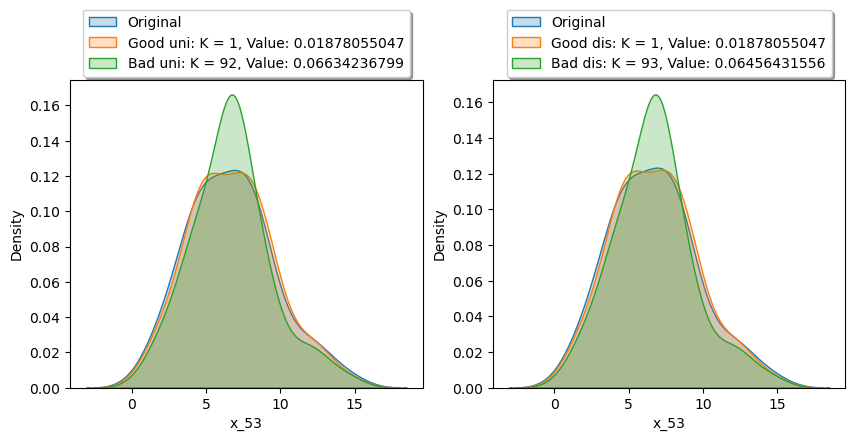

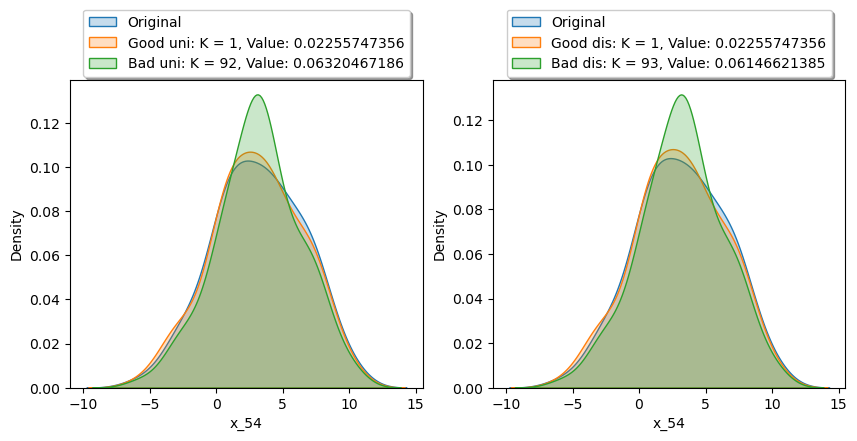

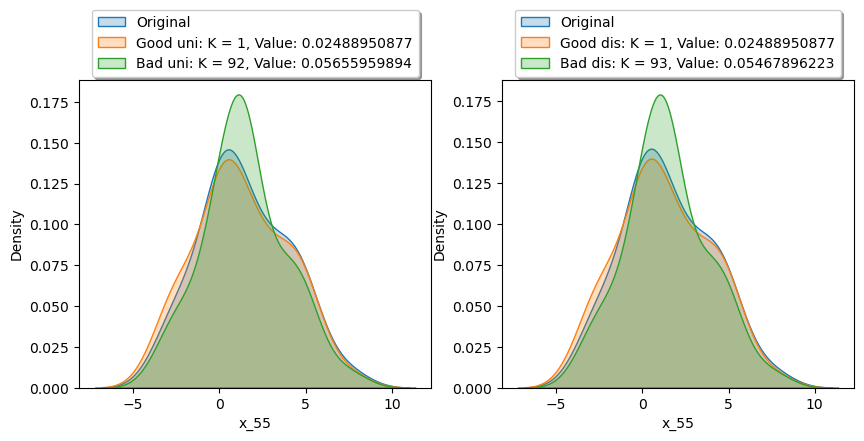

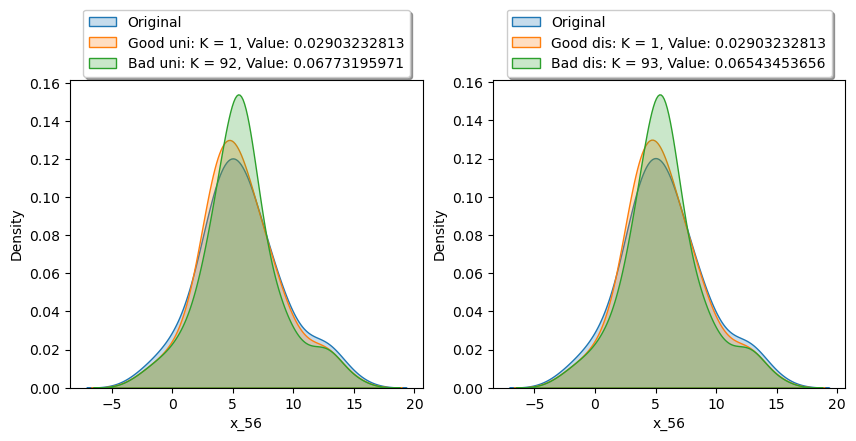

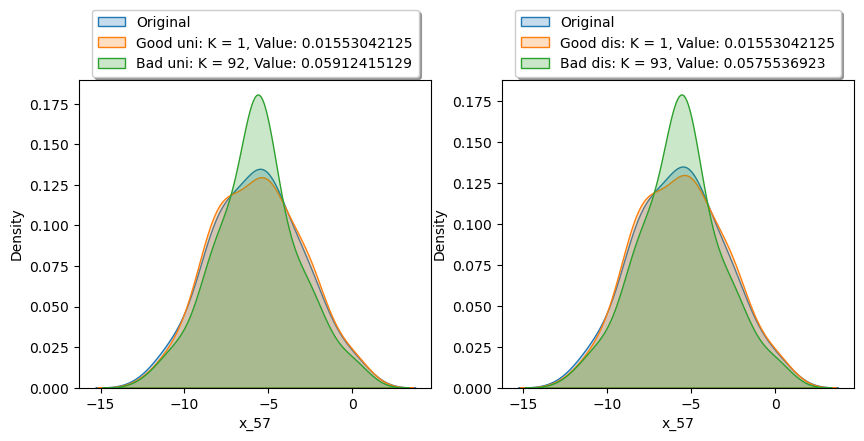

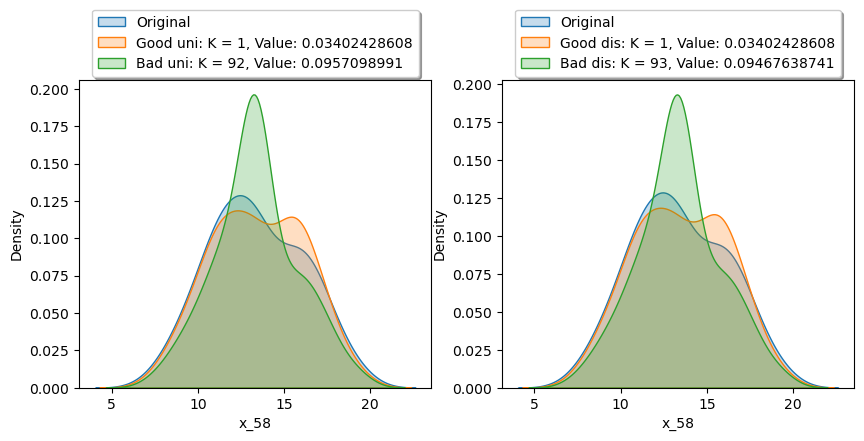

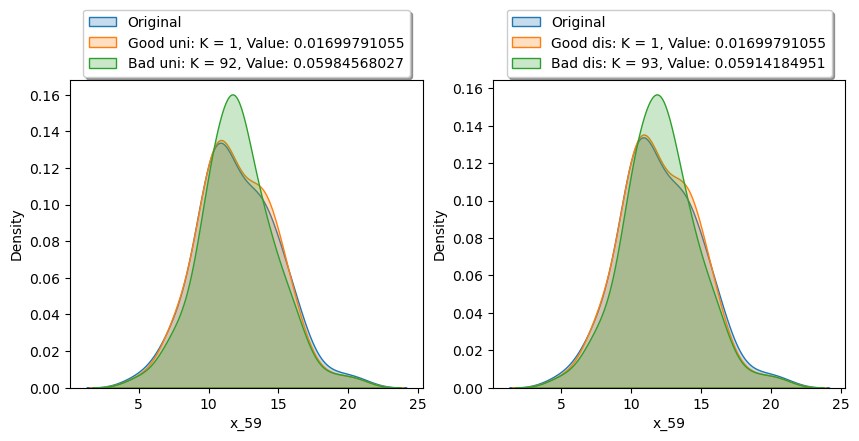

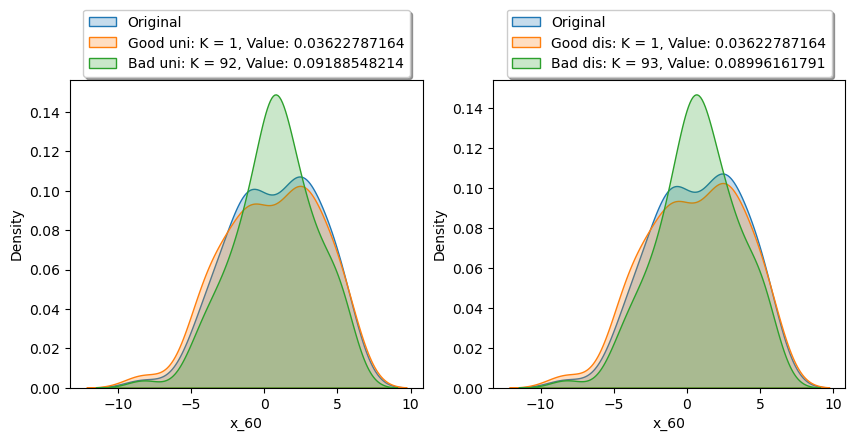

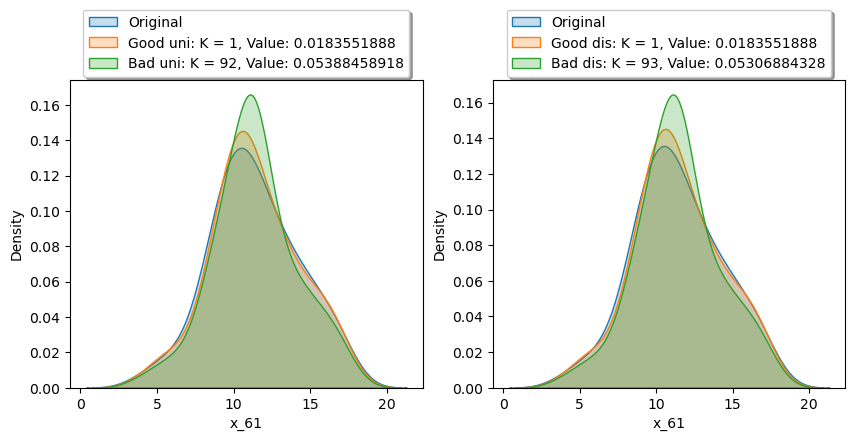

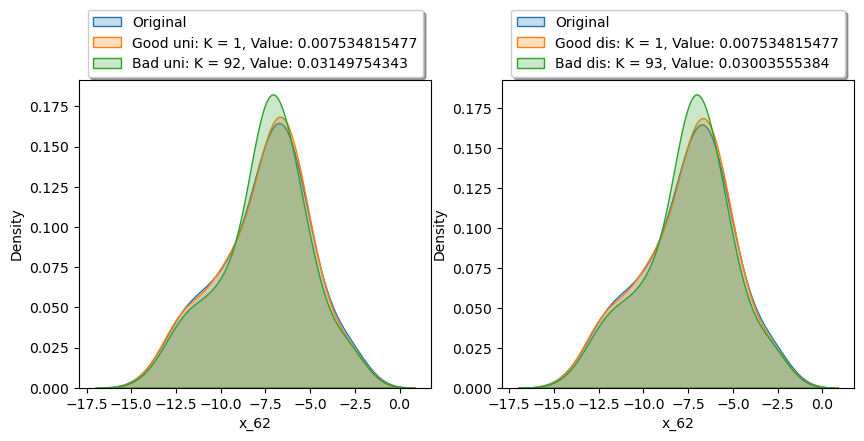

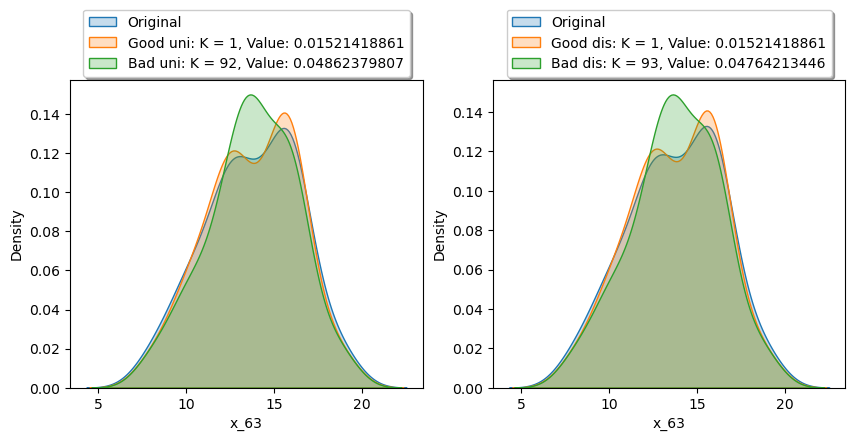

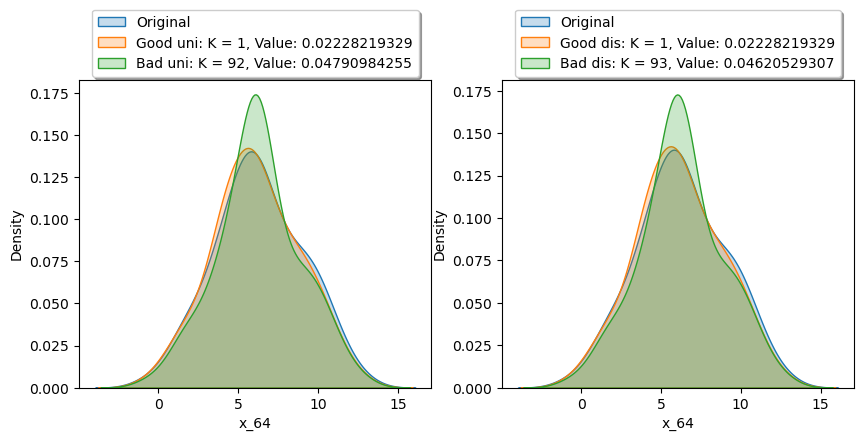

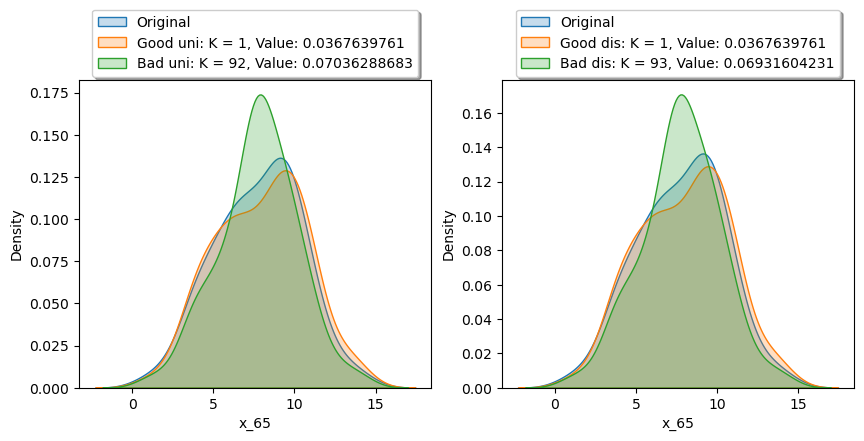

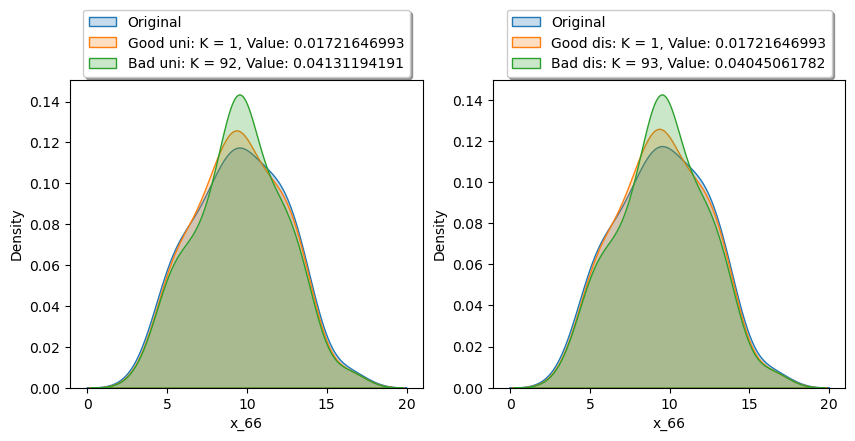

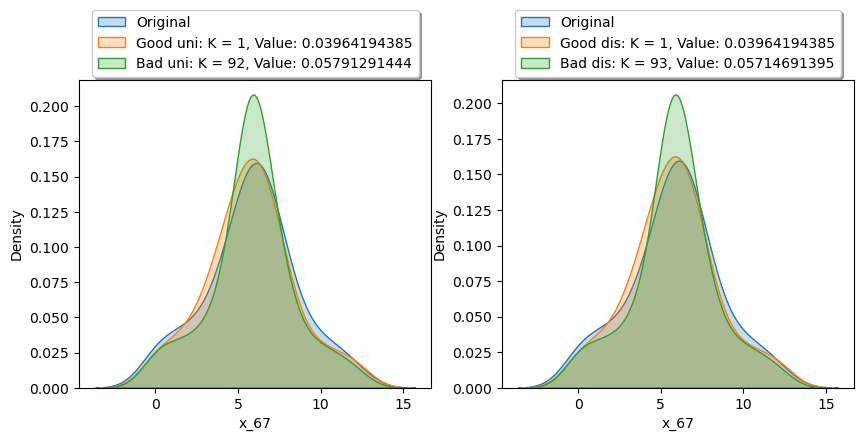

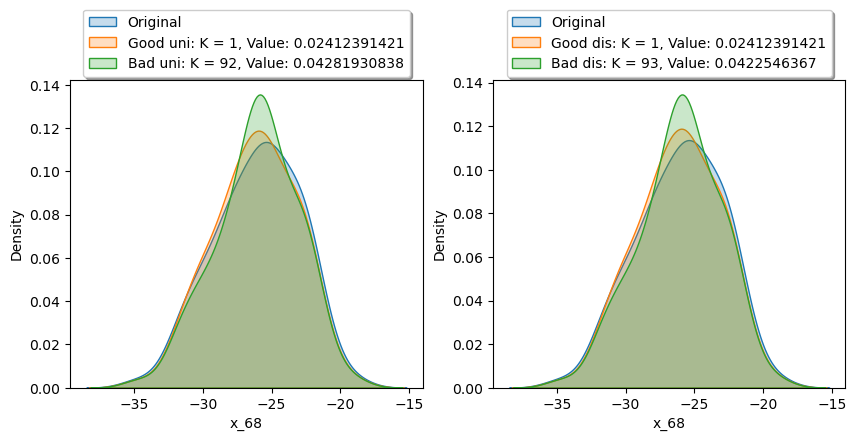

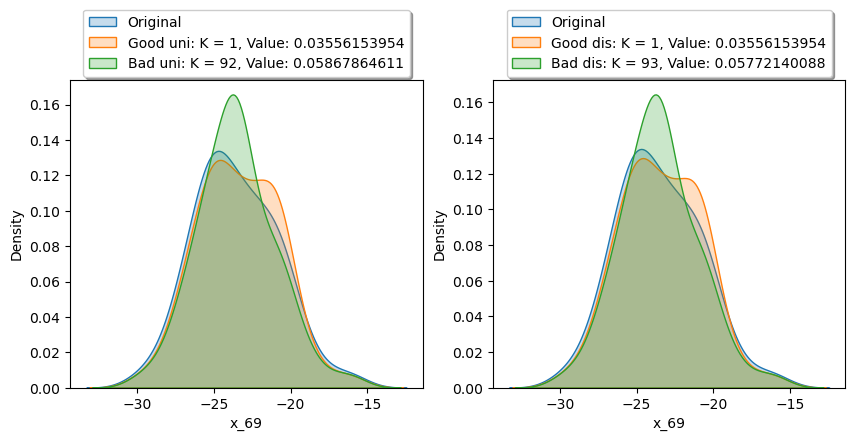

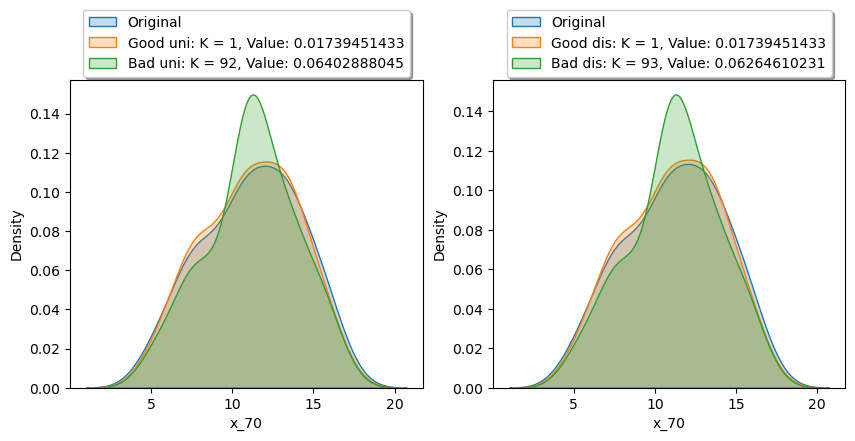

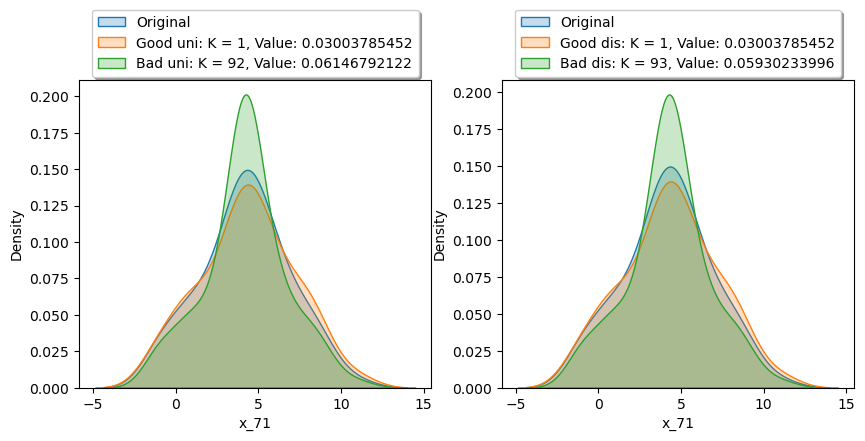

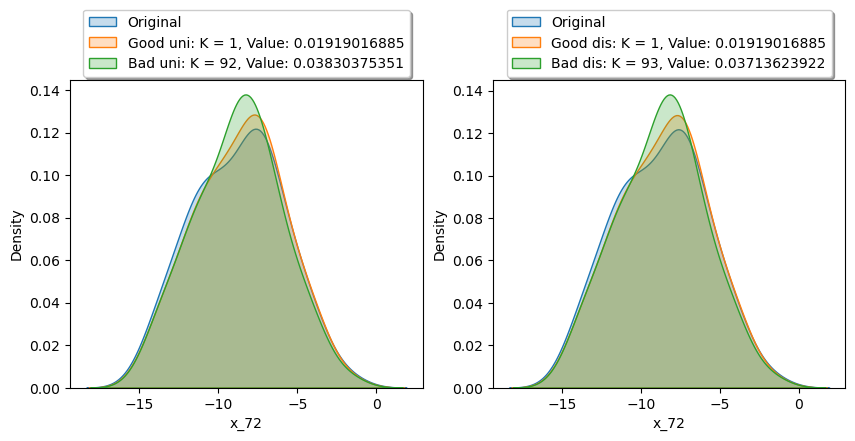

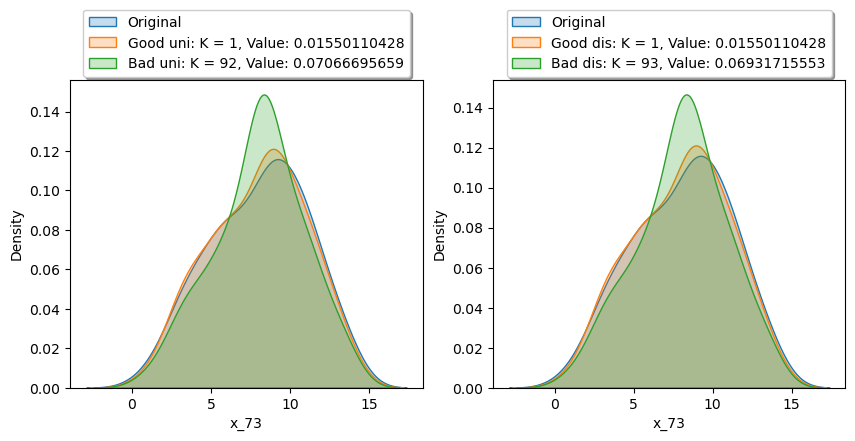

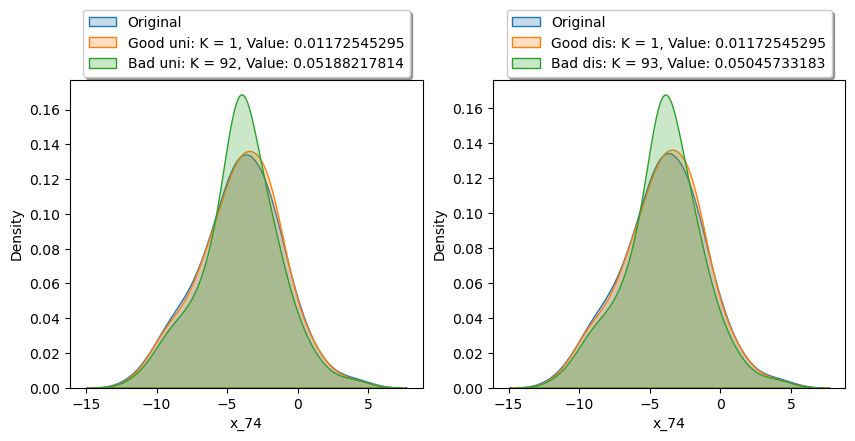

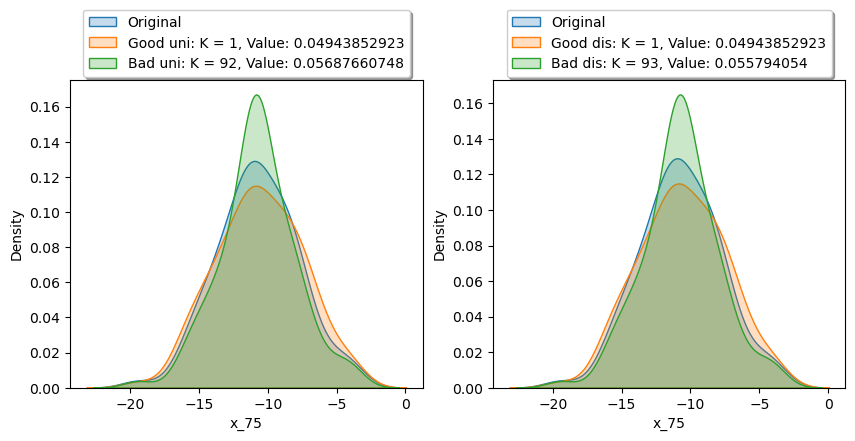

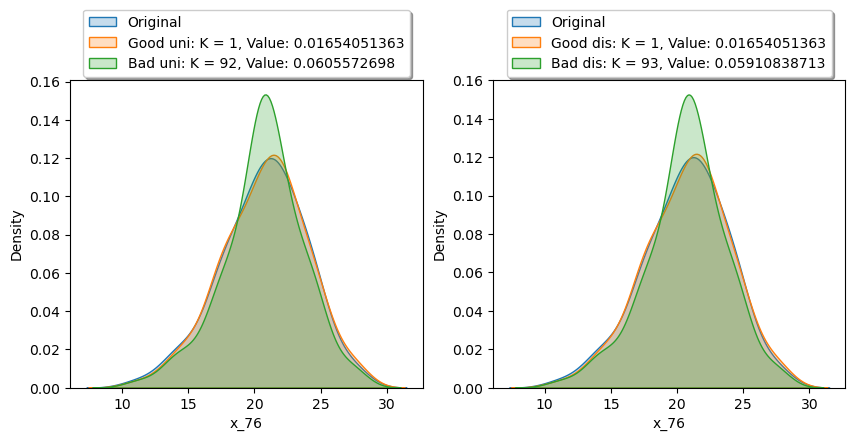

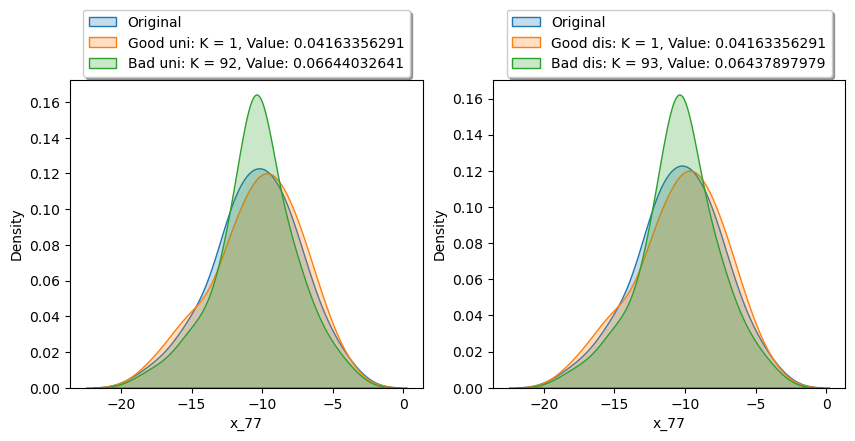

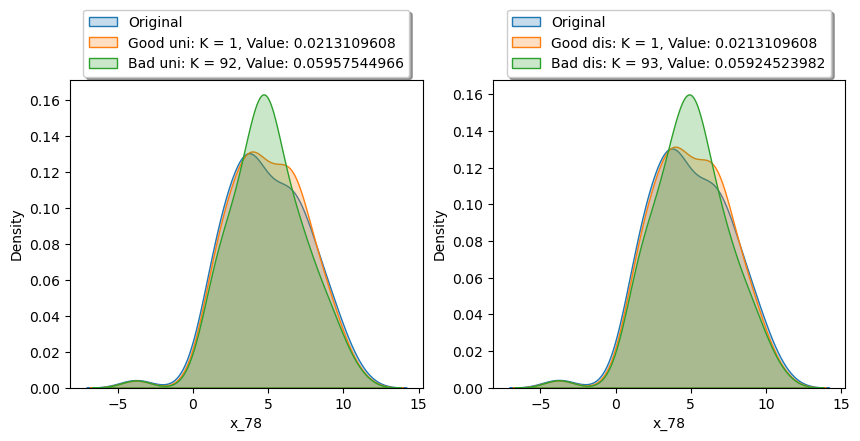

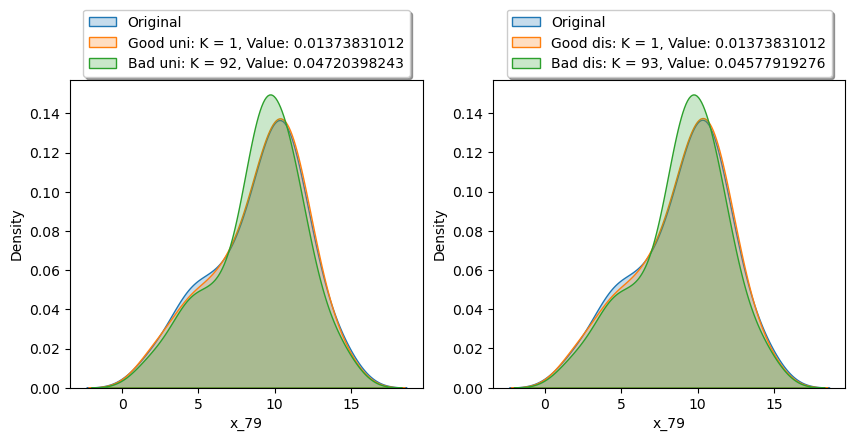

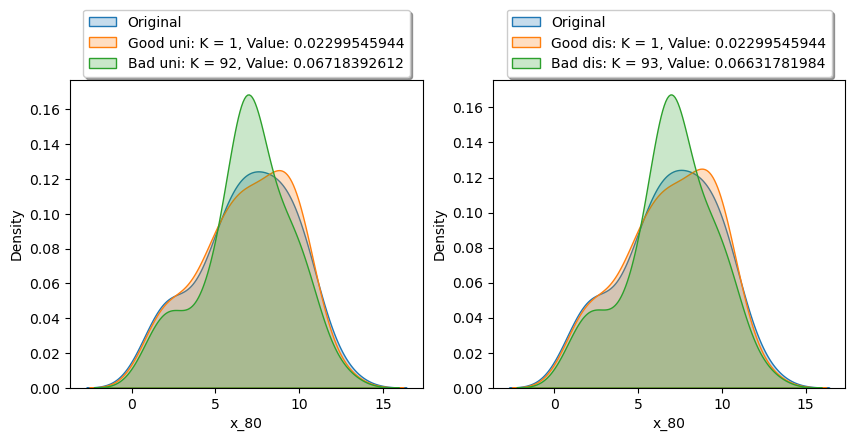

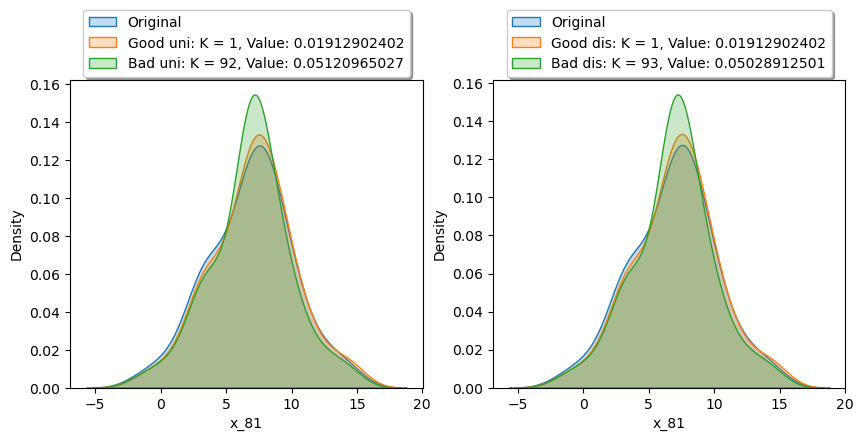

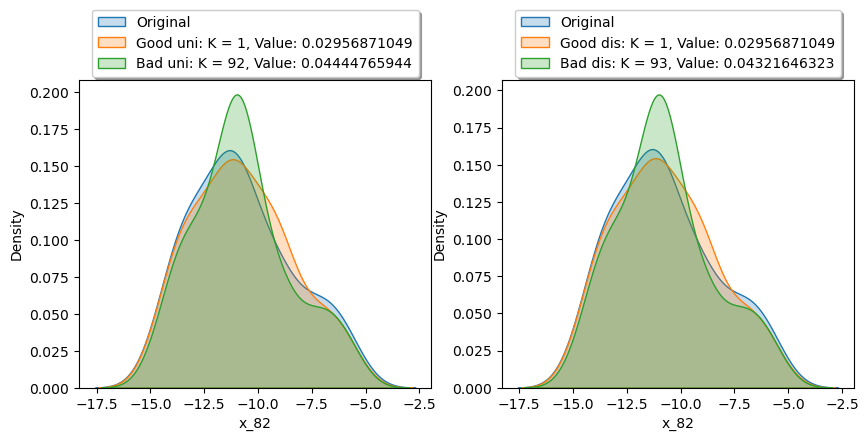

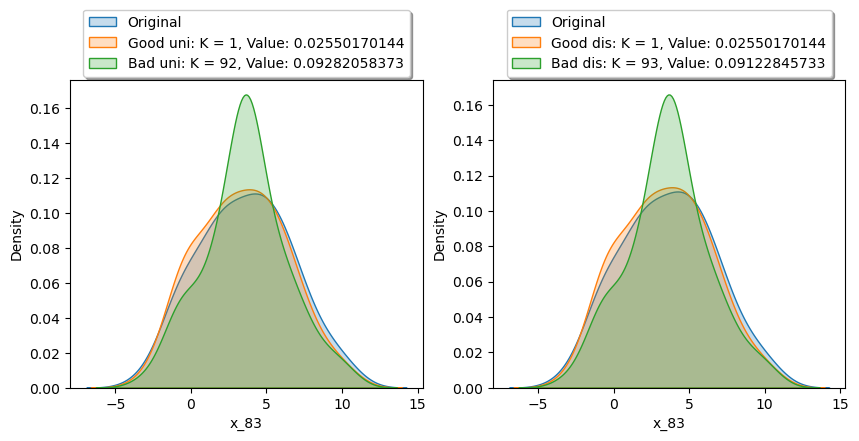

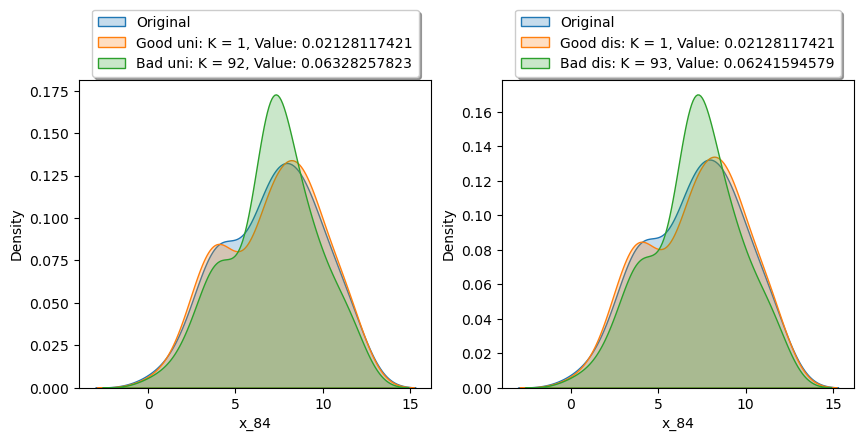

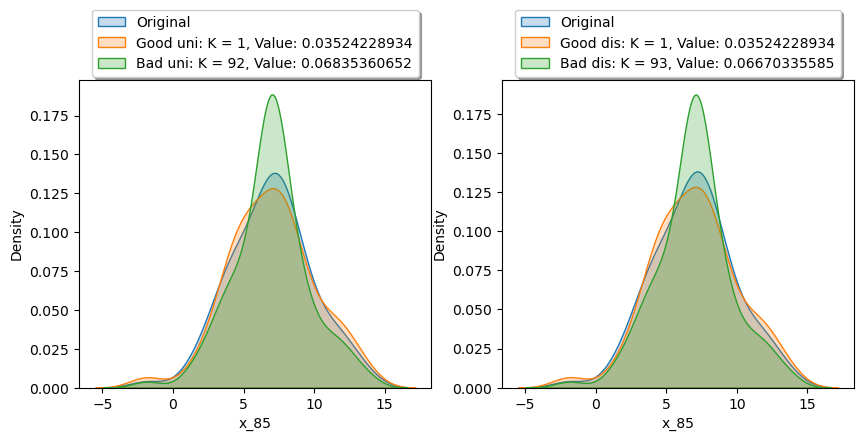

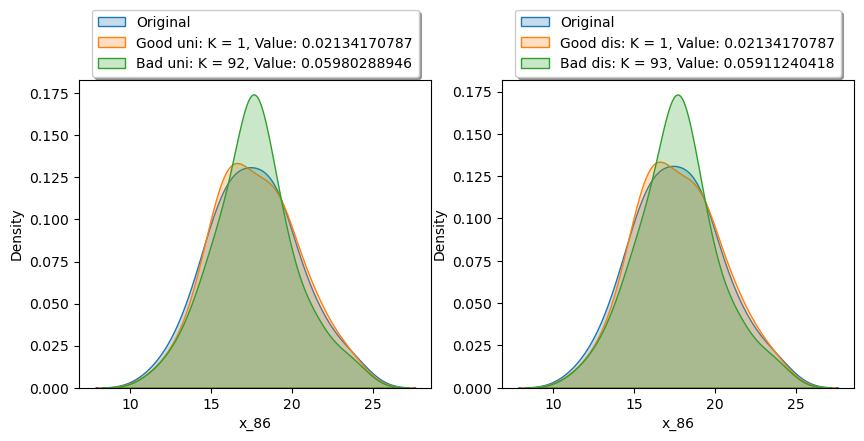

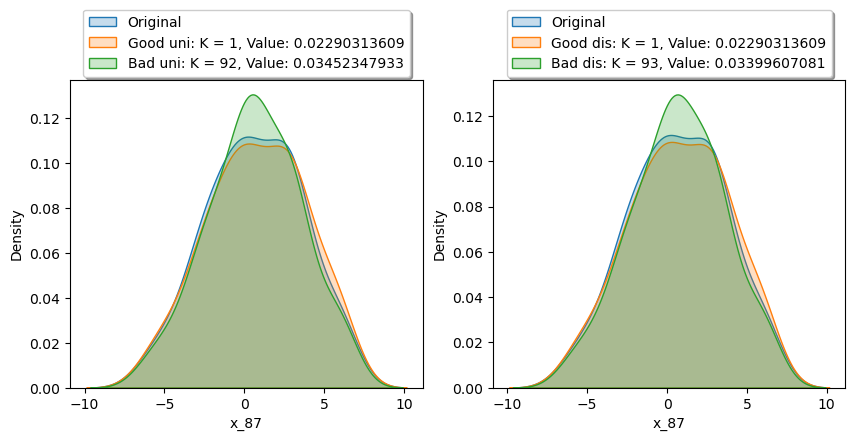

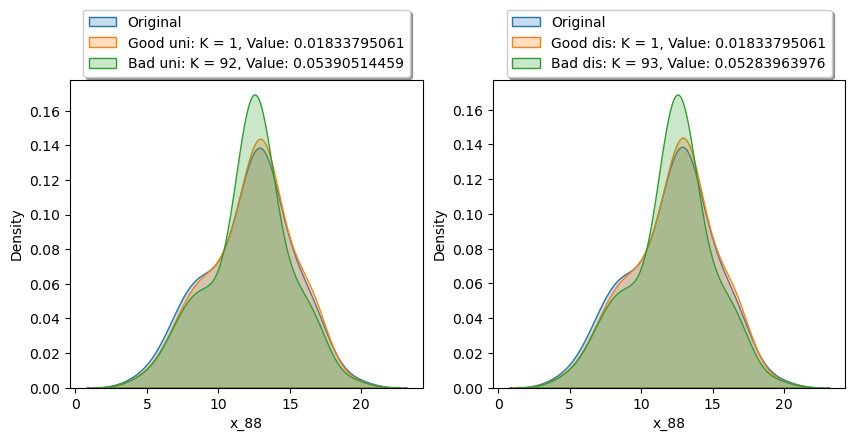

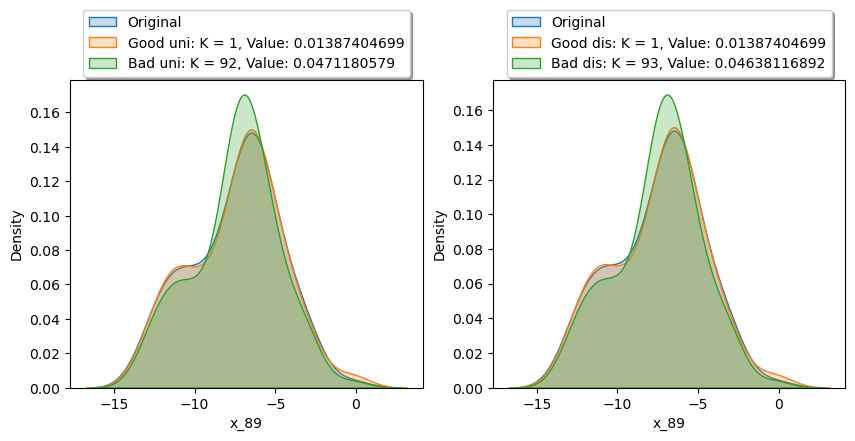

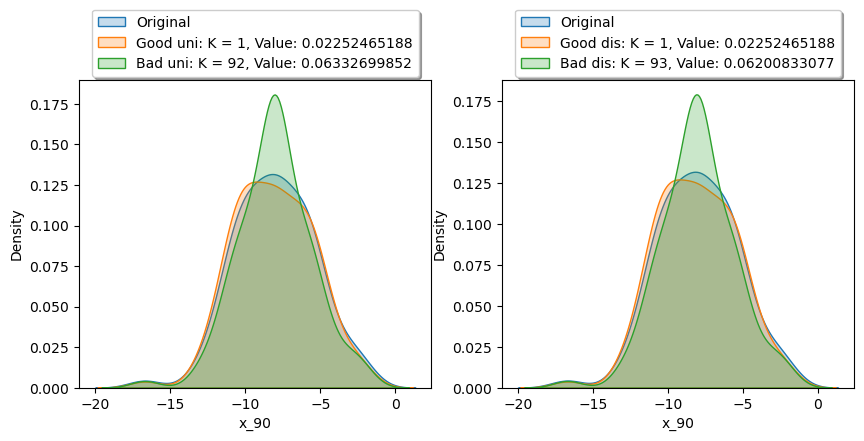

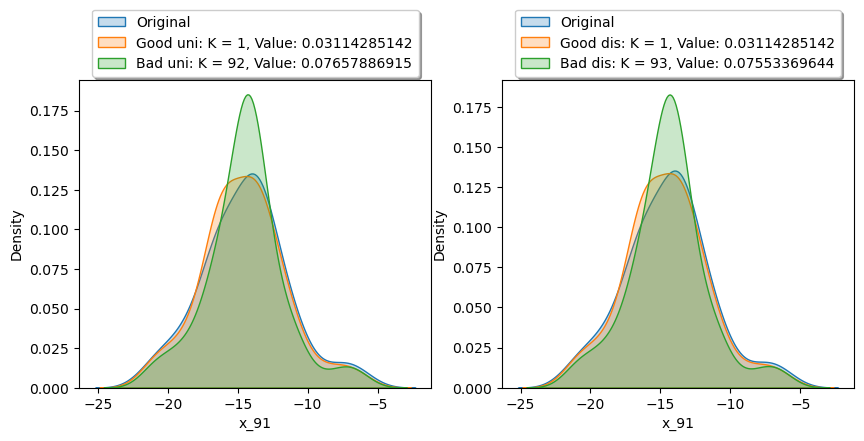

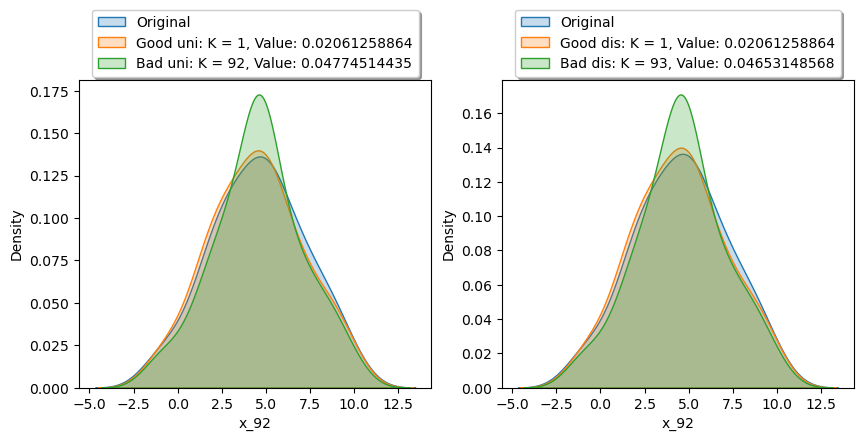

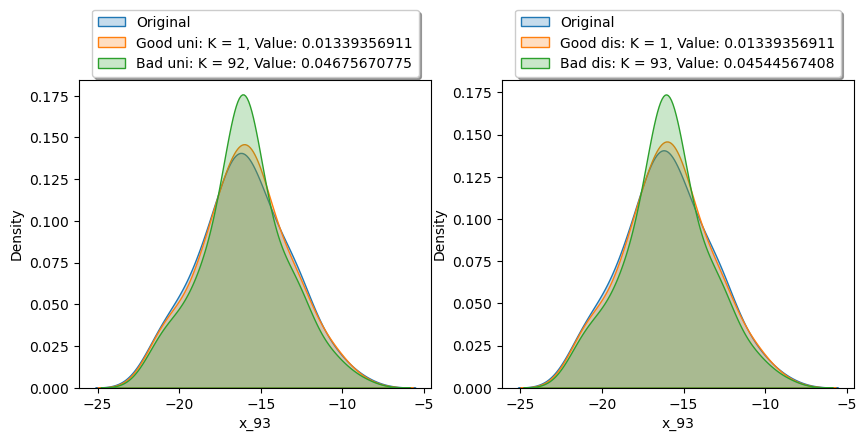

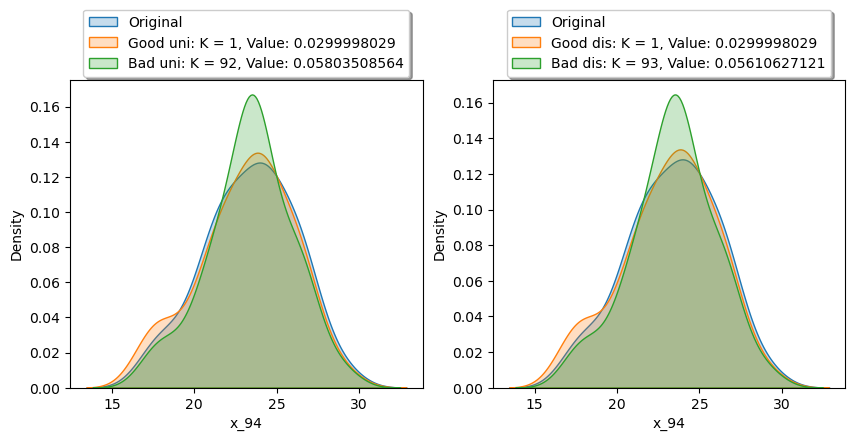

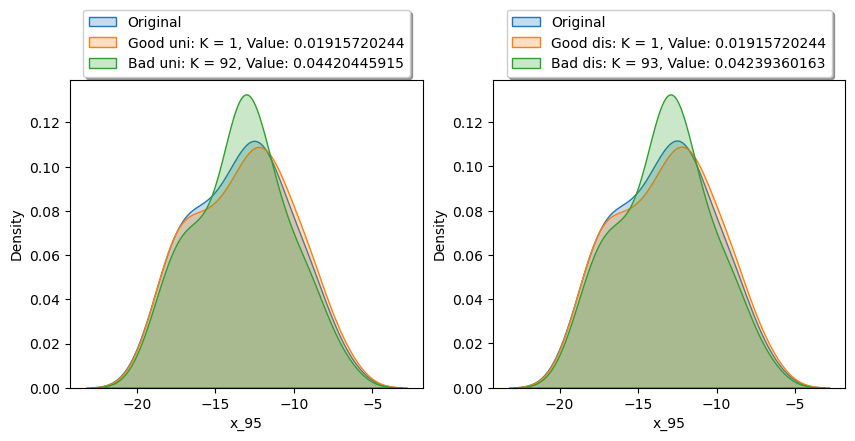

In [311]:
for col in data.columns[:96]:
    good_uni = compute_jensen_shannon_divergence(data[col], data_good_uni[col])
    bad_uni  = compute_jensen_shannon_divergence(data[col], data_bad_uni[col])
    good_dis = compute_jensen_shannon_divergence(data[col], data_good_dis[col])
    bad_dis  = compute_jensen_shannon_divergence(data[col], data_bad_dis[col])
    
    fig, ax = plt.subplots(1, 2, figsize =(10,4))
    
    sns.kdeplot(data[col], fill=True, label='Original', ax=ax[0])
    sns.kdeplot(data_good_uni[col], fill=True, label=f'Good uni: K = {num_good_uni:.3g}, Value: {good_uni:.10g}', ax=ax[0])
    sns.kdeplot(data_bad_uni[col], fill=True, label=f'Bad uni: K = {num_bad_uni:.3g}, Value: {bad_uni:.10g}', ax=ax[0])
    ax[0].set_title('Uniform knn')
    ax[0].set_xlabel(col)
    ax[0].set_ylabel('Density')

    sns.kdeplot(data[col], fill=True, label='Original', ax=ax[1])
    sns.kdeplot(data_good_dis[col], fill=True, label=f'Good dis: K = {num_good_dis:.3g}, Value: {good_dis:.10g}', ax=ax[1])
    sns.kdeplot(data_bad_dis[col], fill=True, label=f'Bad dis: K = {num_bad_dis:.3g}, Value: {bad_dis:.10g}', ax=ax[1])
    ax[1].set_title('Distance knn')
    ax[1].set_xlabel(col)
    ax[1].set_ylabel('Density')
    

    ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), fancybox=True, shadow=True, ncol=1)
    ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), fancybox=True, shadow=True, ncol=1)
    
    plt.show()


## Iterative Imputer

In [312]:
data_tot_itr = pd.concat([data.iloc[:,:96],data_encoded], axis=1)
data_tot_itr


y       x_ 1       x_ 2       x_ 3      x_ 4       x_ 5  \
0    90.685036        NaN        NaN  -3.978178 -1.504027 -14.986790   
1    60.844445  26.204958  11.185962  -8.247602 -3.875866 -11.329702   
2    18.062345  18.560873  11.355342  -9.370161 -3.745315 -16.292421   
3    -8.139839  31.896496  10.069040  -9.484426 -1.512786 -11.421909   
4    -4.994792  25.400286        NaN  -3.600959 -2.615988 -15.455676   
..         ...        ...        ...        ...       ...        ...   
95   12.574444  24.821083  14.377228  -7.899269 -5.531786        NaN   
96 -109.414997  20.848176   9.238049 -11.921478 -6.374971 -18.648810   
97  -11.548116  27.160523  10.134287 -10.920363 -3.231409 -18.474369   
98  -35.263761  20.391153  10.180320        NaN -5.296246 -17.612480   
99    0.527999  23.061566   6.863659 -11.654218 -2.896630 -13.324229   

        x_ 6       x_ 7       x_ 8      x_ 9  ...  C_ 4_G  C_ 4_H  C_ 4_I  \
0   0.651581 -37.878245  16.213807 -3.965437  ...       0       0       0   
1   2.637900 -39.617497        NaN -2.442164  ...       1       0       0   
2  -1.831774 -37.584605  14.411348 -2.376175  ...       0       1       0   
3  -5.649180 -42.830037  18.403197 -7.791762  ...       0       0       0   
4  -4.950816 -39.932456        NaN -7.341165  ...       0       0       0   
..       ...        ...        ...       ...  ...     ...     ...     ...   
95 -3.732251        NaN  15.752089       NaN  ...       1       0       0   
96 -3.019048 -41.358696   8.435083 -5.864114  ...       0       0       1   
97 -2.431349 -38.280634  21.150995 -2.531643  ...       0       0       0   
98 -6.472314 -38.292821  12.740686       NaN  ...       0       1       0   
99 -3.733488 -41.189621  17.670513       NaN  ...       0       0       1   

    C_ 4_J  C_ 4_K  C_ 5_G  C_ 5_H  C_ 5_I  C_ 5_J  C_ 5_K  
0        0       1       0       0       0       1       0  
1        0       0       1       0       0       0       0  
2        0       0       1       0       0       0       0  
3        0       1       1       0       0       0       0  
4        0       1       0       1       0       0       0  
..     ...     ...     ...     ...     ...     ...     ...  
95       0       0       1       0       0       0       0  
96       0       0       0       0       0       0       1  
97       0       1       0       0       0       1       0  
98       0       0       1       0       0       0       0  
99       0       0       0       0       1       0       0  

[100 rows x 117 columns]

In [324]:
X = data_tot_itr.iloc[:, 1:]  
y = data_tot_itr.iloc[:, 0]  
imputer = IterativeImputer(max_iter=30)
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

InvalidParameterError: The 'estimator' parameter of IterativeImputer must be None or an object implementing 'fit' and 'predict'. Got KNNImputer(n_neighbors=1) instead.

In [314]:
X_imputed.iloc[:,95:100] = X_imputed.iloc[:,95:100].apply(replace_max_value, axis=1)
X_imputed.iloc[:, 94:].head()


x_95  C_ 1_G  C_ 1_H  C_ 1_I  C_ 1_J  C_ 1_K  C_ 2_H  C_ 3_G  C_ 3_H  \
0  -9.913837     0.0     1.0     0.0     0.0     0.0     1.0     0.0     0.0   
1  -7.015803     0.0     0.0     0.0     0.0     1.0     1.0     0.0     0.0   
2 -14.795709     0.0     0.0     1.0     0.0     0.0     1.0     1.0     0.0   
3  -9.365574     0.0     1.0     0.0     0.0     0.0     1.0     0.0     0.0   
4 -17.240003     1.0     0.0     0.0     0.0     0.0     1.0     0.0     1.0   

   C_ 3_I  ...  C_ 4_G  C_ 4_H  C_ 4_I  C_ 4_J  C_ 4_K  C_ 5_G  C_ 5_H  \
0     1.0  ...     0.0     0.0     0.0     0.0     1.0     0.0     0.0   
1     0.0  ...     1.0     0.0     0.0     0.0     0.0     1.0     0.0   
2     0.0  ...     0.0     1.0     0.0     0.0     0.0     1.0     0.0   
3     0.0  ...     0.0     0.0     0.0     0.0     1.0     1.0     0.0   
4     0.0  ...     0.0     0.0     0.0     0.0     1.0     0.0     1.0   

   C_ 5_I  C_ 5_J  C_ 5_K  
0     0.0     1.0     0.0  
1     0.0     0.0     0.0  
2     0.0     0.0     0.0  
3     0.0     0.0     0.0  
4     0.0     0.0     0.0  

[5 rows x 22 columns]

In [315]:
data_itr = pd.concat([data['y'], X_imputed], axis = 1)
data_itr.head()

y       x_ 1       x_ 2      x_ 3      x_ 4       x_ 5      x_ 6  \
0  90.685036  23.976361  13.457687 -3.978178 -1.504027 -14.986790  0.651581   
1  60.844445  26.204958  11.185962 -8.247602 -3.875866 -11.329702  2.637900   
2  18.062345  18.560873  11.355342 -9.370161 -3.745315 -16.292421 -1.831774   
3  -8.139839  31.896496  10.069040 -9.484426 -1.512786 -11.421909 -5.649180   
4  -4.994792  25.400286  13.850281 -3.600959 -2.615988 -15.455676 -4.950816   

        x_ 7       x_ 8      x_ 9  ...  C_ 4_G  C_ 4_H  C_ 4_I  C_ 4_J  \
0 -37.878245  16.213807 -3.965437  ...     0.0     0.0     0.0     0.0   
1 -39.617497  19.182521 -2.442164  ...     1.0     0.0     0.0     0.0   
2 -37.584605  14.411348 -2.376175  ...     0.0     1.0     0.0     0.0   
3 -42.830037  18.403197 -7.791762  ...     0.0     0.0     0.0     0.0   
4 -39.932456  15.228663 -7.341165  ...     0.0     0.0     0.0     0.0   

   C_ 4_K  C_ 5_G  C_ 5_H  C_ 5_I  C_ 5_J  C_ 5_K  
0     1.0     0.0     0.0     0.0     1.0     0.0  
1     0.0     1.0     0.0     0.0     0.0     0.0  
2     0.0     1.0     0.0     0.0     0.0     0.0  
3     1.0     1.0     0.0     0.0     0.0     0.0  
4     1.0     0.0     1.0     0.0     0.0     0.0  

[5 rows x 117 columns]

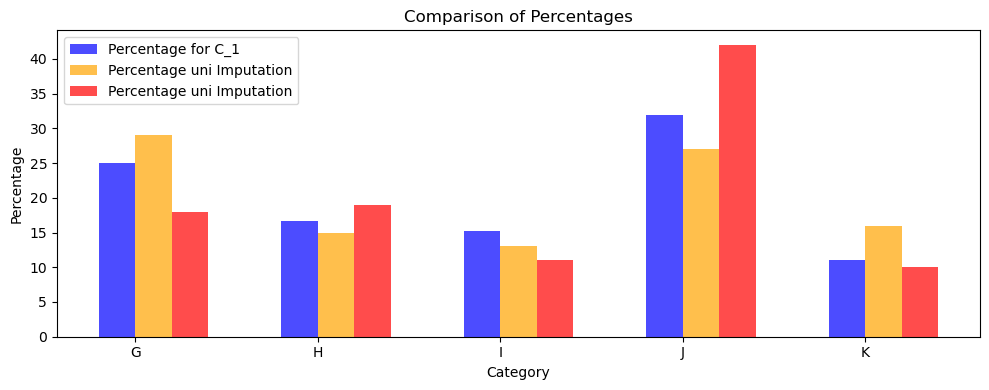

Sum of percentages for count_orginal: 100.0
Sum of percentages for count_uni: 100.0


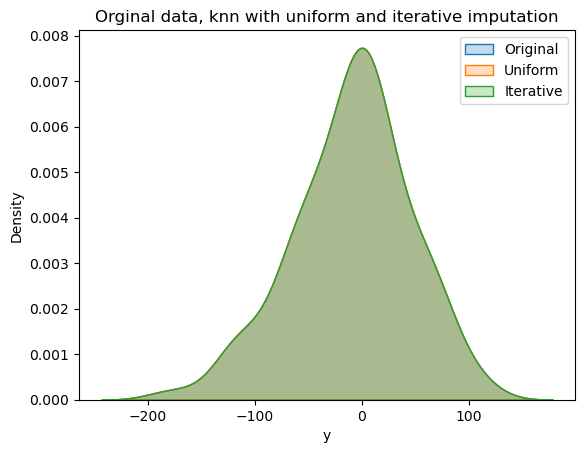

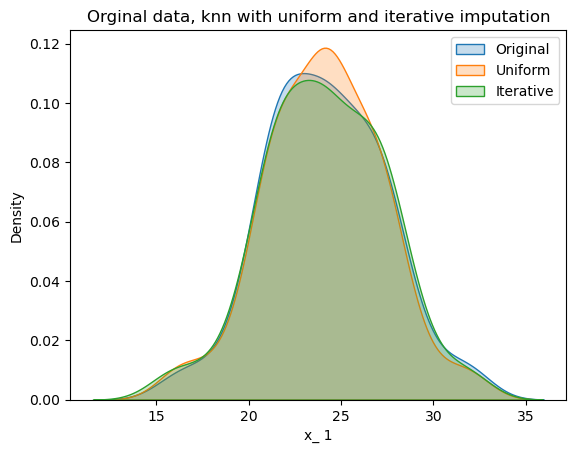

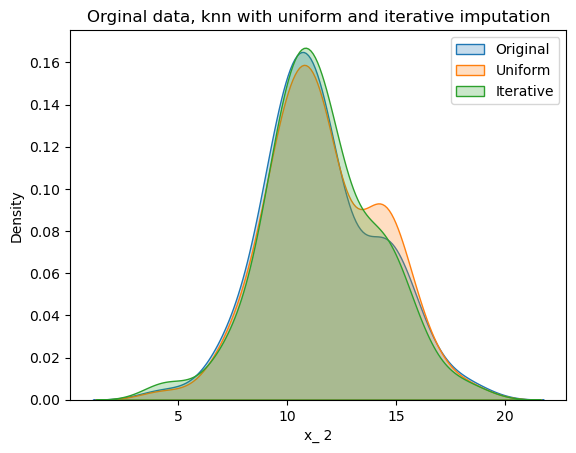

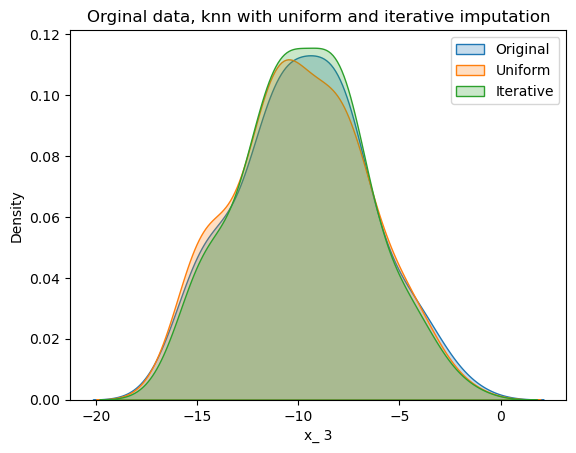

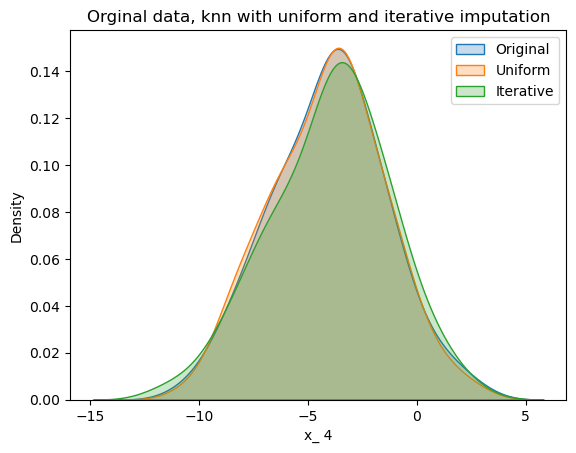

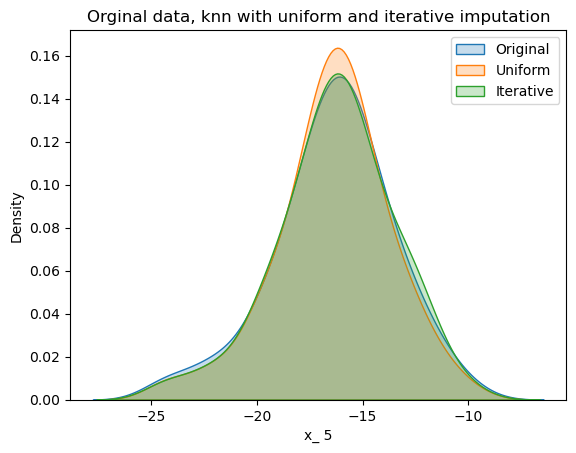

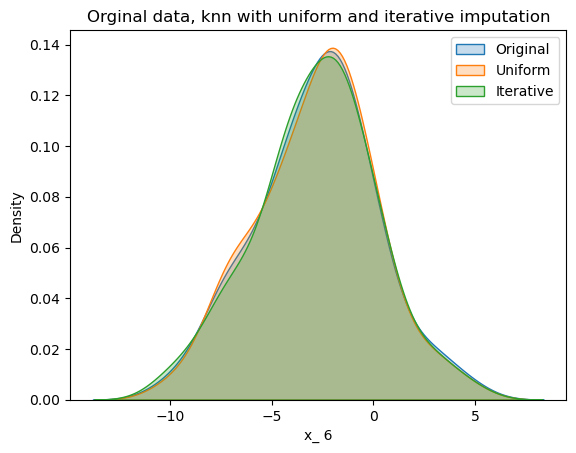

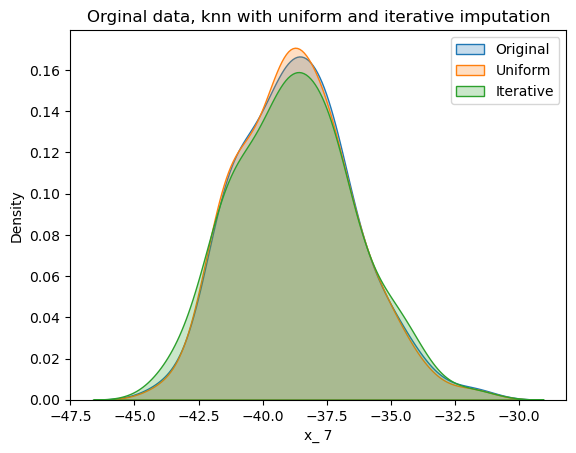

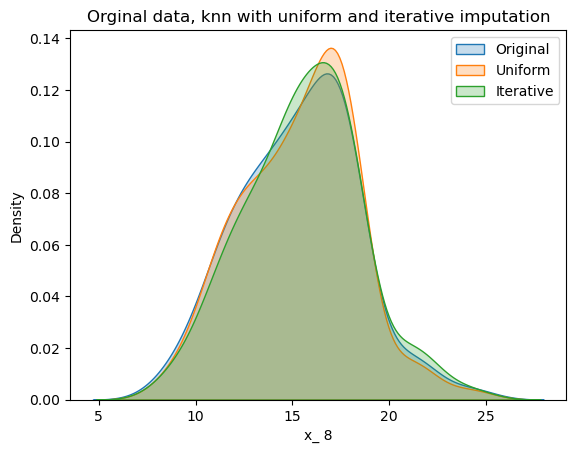

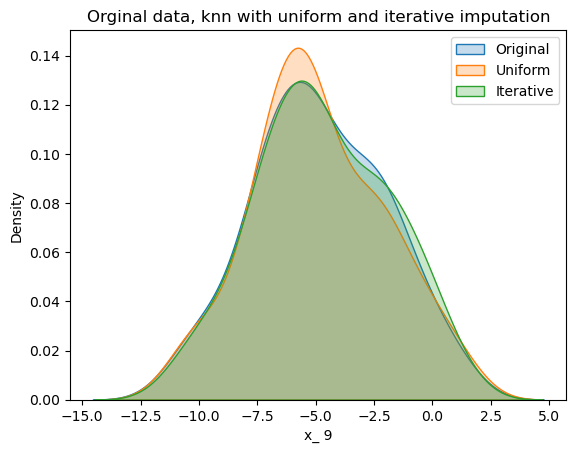

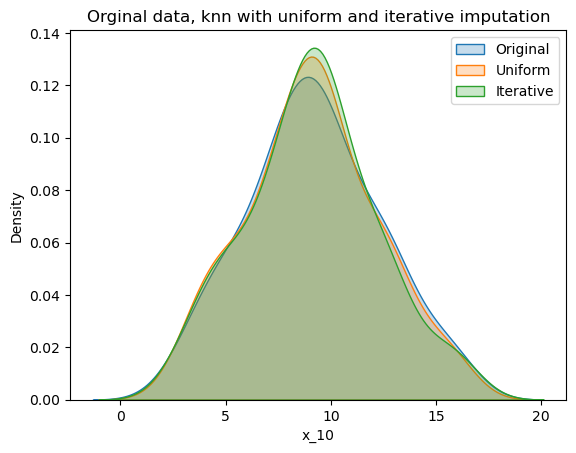

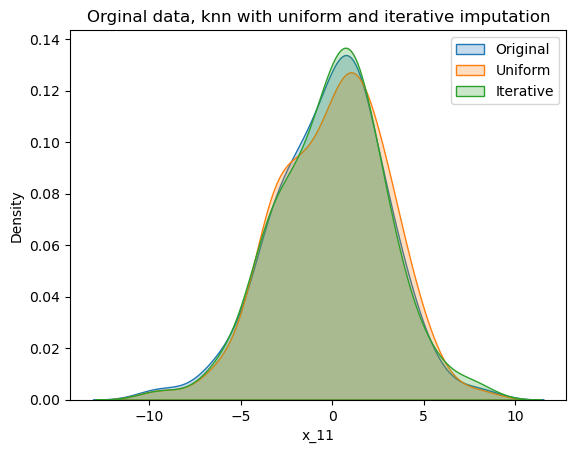

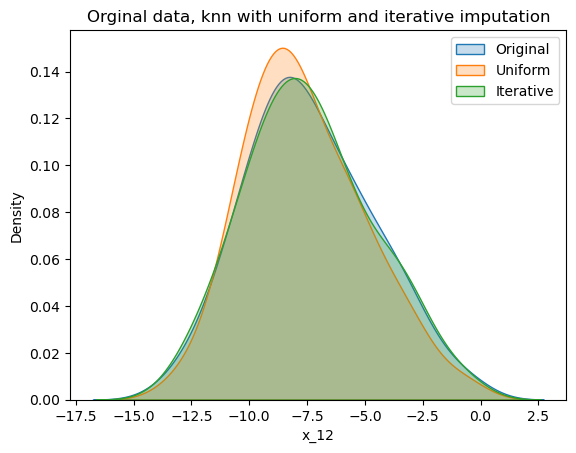

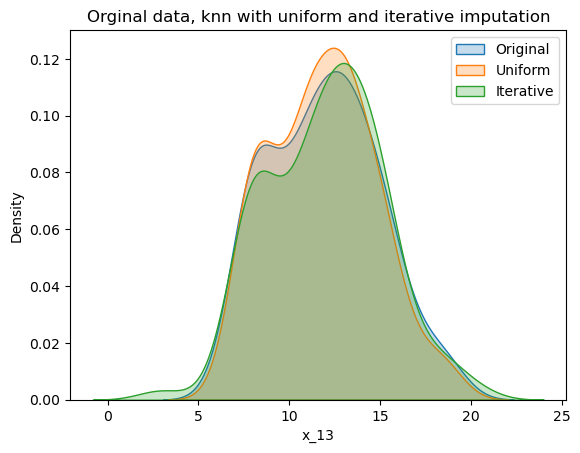

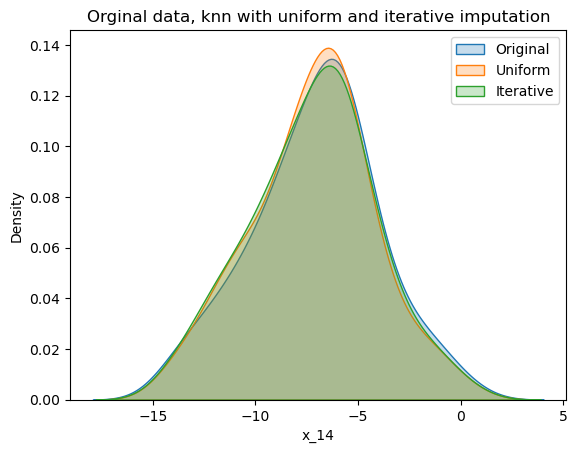

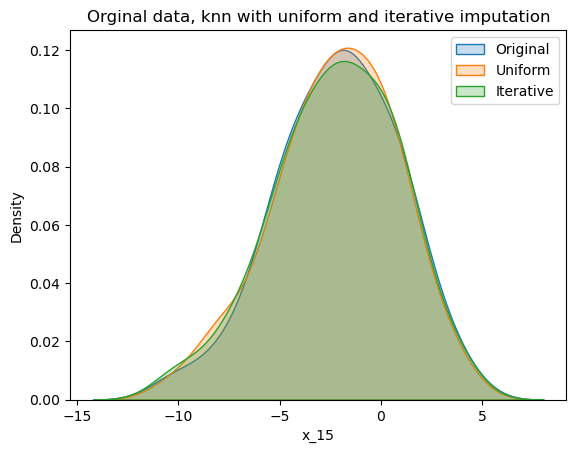

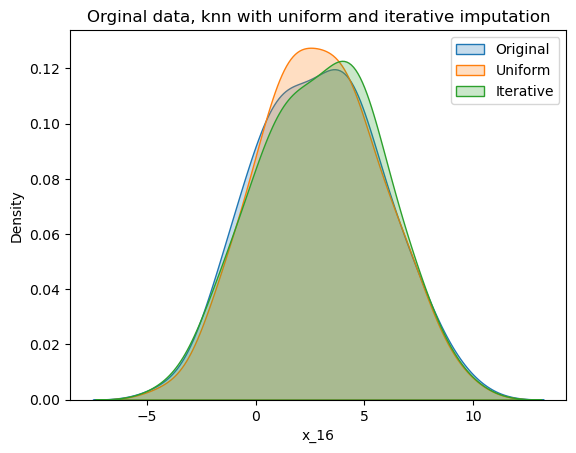

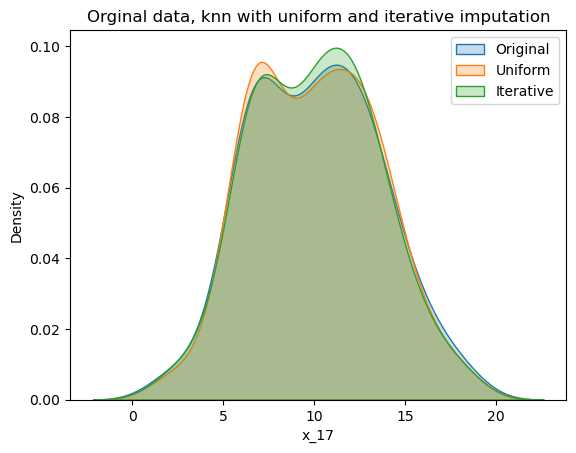

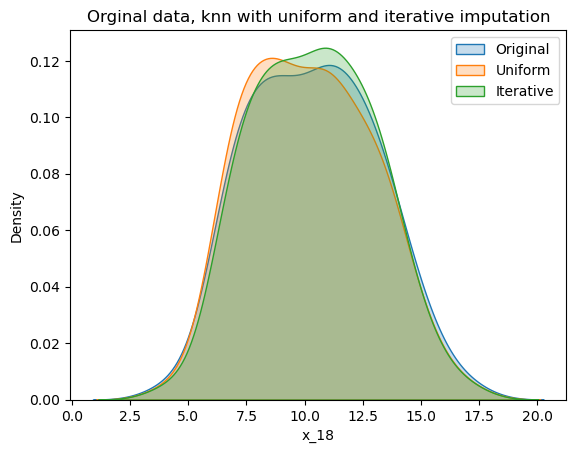

KeyboardInterrupt: 

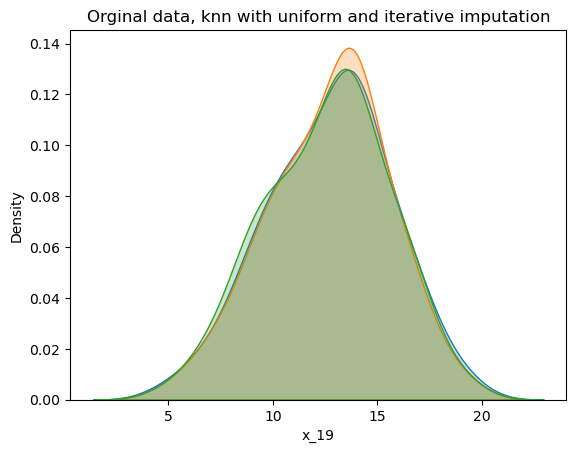

In [323]:
count_orginal = data_cat['C_ 1'].value_counts(dropna=True)
count_uni = data_good_uni.iloc[:, 96:101].sum()
count_itr = data_itr.iloc[:, 96:101].sum()

percentages_orginal = count_orginal / count_orginal.sum() * 100
percentages_uni = count_uni / count_uni.sum() * 100
percentages_itr = count_itr / count_itr.sum() * 100

percentages_orginal_sorted = percentages_orginal.sort_index()
percentages_uni_sorted = percentages_uni.sort_index()
percentages_itr_sorted = percentages_itr.sort_index()
index = np.arange(len(percentages_orginal_sorted))
bar_width = 0.2

plt.figure(figsize=(10, 4))

plt.bar(index, percentages_orginal_sorted, bar_width, color='blue', alpha=0.7, label='Percentage for C_1')
plt.bar(index + bar_width, percentages_uni_sorted, bar_width, color='orange', alpha=0.7, label='Percentage uni Imputation')
plt.bar(index + 2*bar_width, percentages_itr_sorted, bar_width, color='red', alpha=0.7, label='Percentage itr Imputation')

plt.title('Comparison of Percentages')
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.xticks(index + bar_width / 2, percentages_orginal_sorted.index)
plt.legend()
plt.tight_layout()
plt.show()

print("Sum of percentages for count_orginal:", percentages_orginal.sum())
print("Sum of percentages for count_uni:", percentages_uni.sum())

plt.show()
for col in data.columns[:96]:

    sns.kdeplot(data[col], fill=True, label='Original')
    sns.kdeplot(data_good_uni[col], fill=True, label='Uniform')
    sns.kdeplot(data_itr[col], fill=True, label='Iterative')
    plt.title('Orginal data, knn with uniform and iterative imputation')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    
    plt.show()

## Iterative og KNN imputer